In [1]:
"""
-*- coding: utf-8 -*- Created on Fri 21 2020
@author: Thiago Pinho
@colaborators: Thiago Russo, Emmanuel Perotto
"""


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation as LDA
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from string import punctuation
from tqdm.notebook import tqdm
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim import models
import warnings
from preprocessing import generate_freq_dist_plot, generate_wordcloud
warnings.simplefilter("ignore", DeprecationWarning)

## Constants
For better code management, the constants used in this notebook will be listed bellow.

In [2]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "feeds_label"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
POSSIBLE_TEXT_VARIABLES = ["CONTENT", "TITLE"]

## Load raw data and start to treat the it's structure
We'll have a first look at the raw data and after analysing it's structure we can fix missing values(By dropping or artificially inserting then). We can encode or adjust categorical data if needed, fix column names and also drop unnused colummns.

In [3]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.info())
print()
print(df_ribon_news['Label_Train'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB
None

['Animais' 'Solidariedade' 'Familia' 'Criancas' 'Proposito' 'Diversidade'
 'Educacao' 'Ecologia' 'Saude' 'Idosos' 'Ciencia' 'Celebracao' 'Etnias'
 'Esporte' 'Cultura' 'proposito' 'Empreendedorismo' 'empreendedorismo'
 'solidariedade' 'diversidade' 'celebracao' 'ecologia' 'etnias' 'ciencia'
 'saude' 'cultura' 'educacao' 'criancas']


### Results
Based on the previous step it's possible to notice two things:

1) First is that the column labels are not all uppercase or lowercase. 

2) The categories avaiable to classify are not all in the same case either which could lead to later confunsion on the real number of categories the model should classify.

So we will fix by making: 

1) All **column names** will be **uppercase**

2) All **target categories** will also be **uppercase**

In [4]:
"""  Preprocessing the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
""" Converting all labels in TARGET_VARIABLE to uppercase """
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
print("Column names are now: ", df_ribon_news.columns.to_list())
print()
print(TARGET_VARIABLE + " categories are now: ", df_ribon_news[TARGET_VARIABLE].unique())

Column names are now:  ['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN']

LABEL_TRAIN categories are now:  ['ANIMAIS' 'SOLIDARIEDADE' 'FAMILIA' 'CRIANCAS' 'PROPOSITO' 'DIVERSIDADE'
 'EDUCACAO' 'ECOLOGIA' 'SAUDE' 'IDOSOS' 'CIENCIA' 'CELEBRACAO' 'ETNIAS'
 'ESPORTE' 'CULTURA' 'EMPREENDEDORISMO']


### Storing partial progress
One of the advantages of jupyter notebook is the possibility of only repeating parts of the code when there is need for it. So let's store our partial progress for more stability and less rework.

In [5]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

In [6]:
"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/ribon/feeds_label_treated.xlsx


## Load and analyse treated data
Now we have treated some structural characteristics of the data and some details, let's analyse the data.

In [7]:
"""  Load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           888 non-null    int64 
 1   PICK_COUNT   888 non-null    int64 
 2   CONTENT      886 non-null    object
 3   TITLE        888 non-null    object
 4   LABEL_TRAIN  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 41.6+ KB
None


### Choosing text data and dropping unwanted variables
Not all columns available in data will be useful for the label classification.

In [8]:
""" In the previous results, we could that are two text variables besides the target: CONTENT and TITLE.
There's also the numeric variable pick_count which is unrelated to label, so let's add it to a unwanted list """
unwanted_columns = set(['PICK_COUNT', 'ID'])

""" As CONTENT is empty in two cases let's compare it to title which is not empty in any case """
compared_columns = set(['CONTENT', 'TITLE'])
columns_stats = []
columns_series = []
for column in compared_columns:
    column_series = df_ribon_news_treated[column]
    columns_stats.append((column_series.str.len().mean(), column_series.str.len().std()))
    columns_series.append(column_series)

for column, stats in zip(compared_columns, columns_stats):
    mean, std = stats
    mean = str(int(mean))
    std = str(int(std))
    print(
        "Column " + column + " mean length was " + mean + " and standard deviation was " + std)


Column CONTENT mean length was 551 and standard deviation was 289
Column TITLE mean length was 70 and standard deviation was 16


### Results
As CONTENT is appears to have more data, it could bring better results. But as two rows have this column empty we would have to drop those. One way around it is to oversample the data by using both as text variables.

In [9]:
unwanted_columns.union(compared_columns)
wanted_columns = set(df_ribon_news_treated.columns).intersection(unwanted_columns)
df_preprocessed_data = pd.DataFrame(columns=[TARGET_VARIABLE, "TEXT_VARIABLE"])
for column in compared_columns:
    df_labels_texts_variables = df_ribon_news_treated[[TARGET_VARIABLE, column]]
    df_labels_texts_variables = df_labels_texts_variables.rename(columns={column:"TEXT_VARIABLE"})
    df_preprocessed_data = df_preprocessed_data.append(df_labels_texts_variables, ignore_index=True)

print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1776 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB
None


### Dealing with missing values
As there are some samples that are empty, they'll not be useful to train or to validate the model. 
Let's drop them

In [10]:
df_preprocessed_data = df_preprocessed_data.dropna()
print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1774 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 41.6+ KB
None


### Label distribution, oversampling and undersampling
One important step is to analyse how the target categories are distributed. That's useful so we can better partition our data, maybe apply some over or undersampling if it's necessary.

Mean number of samples for the target variable is:  110.875
Standard deviation number of samples for the target variable is:  64.94189710810734


ECOLOGIA                     258 Warning         SOLIDARIEDADE               187 Warning   
PROPOSITO                    171 Okay            CULTURA                     158 Okay      
DIVERSIDADE                  144 Okay            ANIMAIS                     134 Okay      
EDUCACAO                     132 Okay            ETNIAS                      130 Okay      
CELEBRACAO                   112 Okay            ESPORTE                      68 Okay      
EMPREENDEDORISMO              64 Okay            CIENCIA                      62 Okay      
SAUDE                         48 Okay            CRIANCAS                     38 Warning   
FAMILIA                       38 Warning         IDOSOS                       30 Warning   



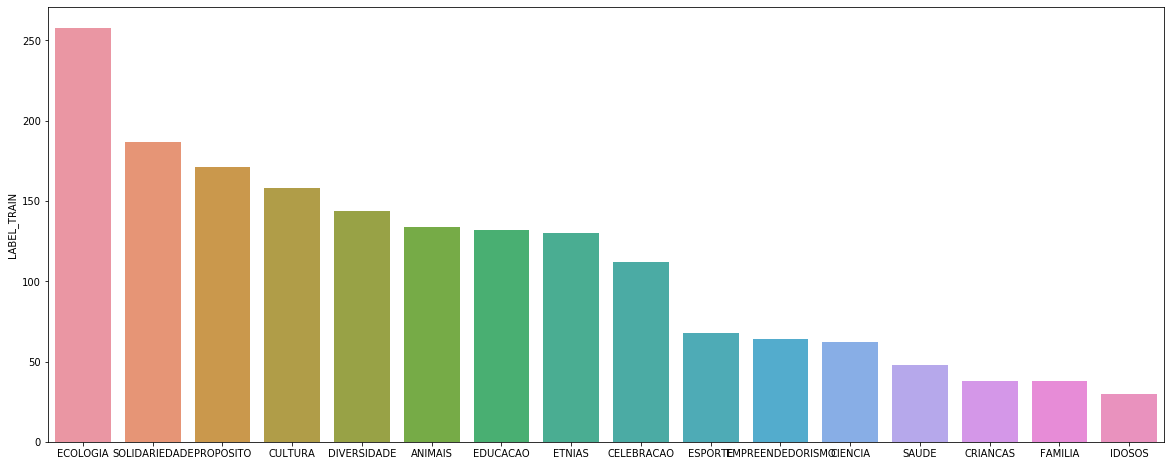

In [11]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
average_samples_per_label = data_labels_count.mean()
standard_deviation_for_labels = data_labels_count.std()
print(
    "Mean number of samples for the target variable is: ",
    average_samples_per_label)
print(
    "Standard deviation number of samples for the target variable is: ",
    standard_deviation_for_labels)

''' Numerical analysis
    One way to analyse the frequency of certain labels is to notice with
    they're too afar from the other labels frequencies average. Let's use
    standard deviation to check it'''
def is_it_further_than_std_deviations( value ):
    is_too_much = value > average_samples_per_label + standard_deviation_for_labels
    is_too_little = value < average_samples_per_label - standard_deviation_for_labels
    if is_too_much or is_too_little:
        message = "Warning"
    else:
        message = "Okay"

    return message

for i in tqdm(range(0, len(data_labels), 2)):
    even_indexed_label = data_labels[i]
    odd_indexed_label = data_labels[i+1]

    print("{0:20}  {1:10} {2:15} {3:20} {4:10} {5:10}".format(
        even_indexed_label, data_labels_count[even_indexed_label], is_it_further_than_std_deviations(data_labels_count[even_indexed_label]),
        odd_indexed_label, data_labels_count[odd_indexed_label], is_it_further_than_std_deviations(data_labels_count[odd_indexed_label])))

''' Visual plotting'''
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Results

Based on the previous step, we can see the categories **ECOLOGIA** and **SOLIDARIEDADE** have **more than the average added by the standard deviation** which can cause the model to overly recognise those labels patterns and make then too sensitive for those. 

On other hand we have the categories **FAMILIA**, **CRIANCAS** and **IDOSOS** with **less than the average subtracted by the standard deviation** which can make the model too specific for those and hardly classify as it.

Let's oversample the least common labels by grouping then. When our pipeline is finely tunned we can use the grouped labels as input for another pipeline trainned only to discern among those.
And also undersample the most common labels by ramdonly select less samples.


Let's check the labels found: 
Underpresented labels:  ['CRIANCAS', 'FAMILIA', 'IDOSOS']
Overrepresented labels:  ['ECOLOGIA', 'SOLIDARIEDADE']
Unchanged Labels:  ['ANIMAIS', 'DIVERSIDADE', 'EDUCACAO', 'CIENCIA', 'CULTURA', 'EMPREENDEDORISMO', 'ESPORTE', 'CELEBRACAO', 'PROPOSITO', 'ETNIAS', 'SAUDE']
SOLIDARIEDADE       175
ECOLOGIA            175
PROPOSITO           171
CULTURA             158
DIVERSIDADE         144
ANIMAIS             134
EDUCACAO            132
ETNIAS              130
CELEBRACAO          112
SCARCE_GROUP        106
ESPORTE              68
EMPREENDEDORISMO     64
CIENCIA              62
SAUDE                48
Name: LABEL_TRAIN, dtype: int64


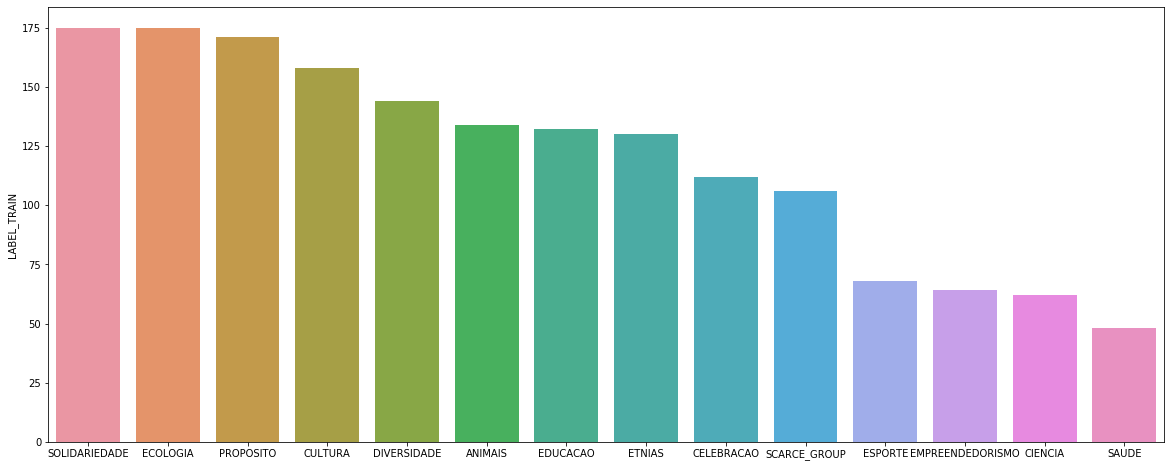

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1774 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 41.6+ KB
None


In [12]:
''' Let's create another dataframe and find which samples will be and how they'll be part of it'''
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = []
over_represented_labels = []
max_number_of_samples = average_samples_per_label + standard_deviation_for_labels
min_number_of_samples = average_samples_per_label - standard_deviation_for_labels
for label in tqdm(data_labels):
    if data_labels_count[label] < min_number_of_samples:
        under_represented_labels.append(label)
    elif data_labels_count[label] > max_number_of_samples:
        over_represented_labels.append(label)

unchanged_labels = list(set(data_labels) - set(under_represented_labels) - set(over_represented_labels))

print("Let's check the labels found: ")
print("Underpresented labels: ", under_represented_labels)
print("Overrepresented labels: ", over_represented_labels)
print("Unchanged Labels: ", unchanged_labels)

df_preprocessed_grouped = pd.DataFrame(columns=df_preprocessed_data.columns)

for label in unchanged_labels:
    unchanged_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(unchanged_rows)

''' Now we have found which ones are under represented we'll add them to the new
    DataFrame and then change the under represented label to SCARCE_GROUP '''
for label in under_represented_labels:
    under_represented_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(under_represented_rows)

GROUP_TARGET_LABEL = 'SCARCE_GROUP'
df_preprocessed_grouped = df_preprocessed_grouped.replace(
    {TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)

""" For the over represented, we'll select some of the samples."""
for label in over_represented_labels:
    over_represented_rows = df_preprocessed_data[
        df_preprocessed_data[TARGET_VARIABLE] == label].sample(int(max_number_of_samples))
    df_preprocessed_grouped = df_preprocessed_grouped.append(over_represented_rows)

print(df_preprocessed_grouped[TARGET_VARIABLE].value_counts())

"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_grouped[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()
print(df_preprocessed_data.info())

### Storing partial progress

In [13]:
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_treated_grouped.xlsx"

In [14]:
"""  Let"s store the  data """
df_preprocessed_grouped.to_excel(excel_filename)

## Data Partition
Now we have treated the data structure and sampling problems. Let's drop unwanted columns.

In [15]:
"""  We then load the data for stability """
df_data = pd.read_excel(excel_filename, index_col=0)
print(df_data.head())

   LABEL_TRAIN                                      TEXT_VARIABLE
0      ANIMAIS  A forte ligação dos cães com o ser humano desp...
13     ANIMAIS  A cadelinha Lana compartilha seu cobertor com ...
21     ANIMAIS  Elefantes órfãos no Quênia possuem um destino ...
22     ANIMAIS  Quando adotamos um cachorro, ele também salva ...
23     ANIMAIS  Voluntários tiveram uma ótima ideia nesse inve...


## Text Filter(Preprocessing)

Before we train the model, it's necessary to tokenize words, find their lemmas and discard some words that could mislead the model.

Let's take a first look at the text variable.

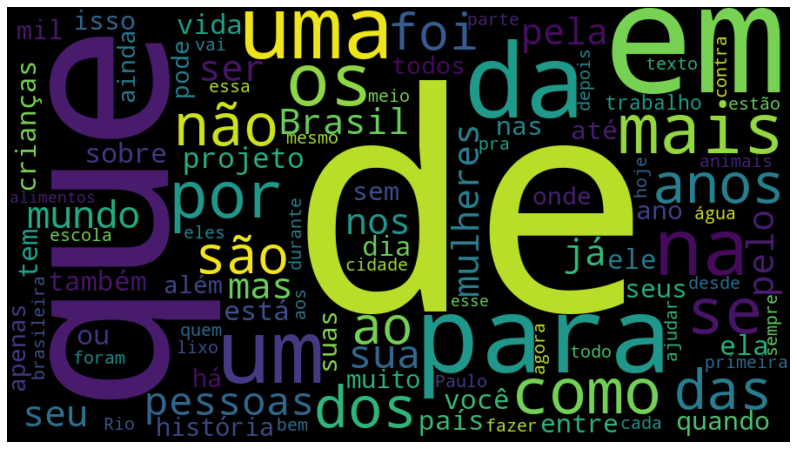

,       5008
de      4378
.       3034
a       2476
e       2436
que     1884
o       1865
do      1381
em      1309
para    1272
da      1262
um       877
com      856
uma      836
no       772
é        762
na       691
mais     541
os       520
por      442
A        433
as       429
se       421
-        412
como     406
dtype: int64


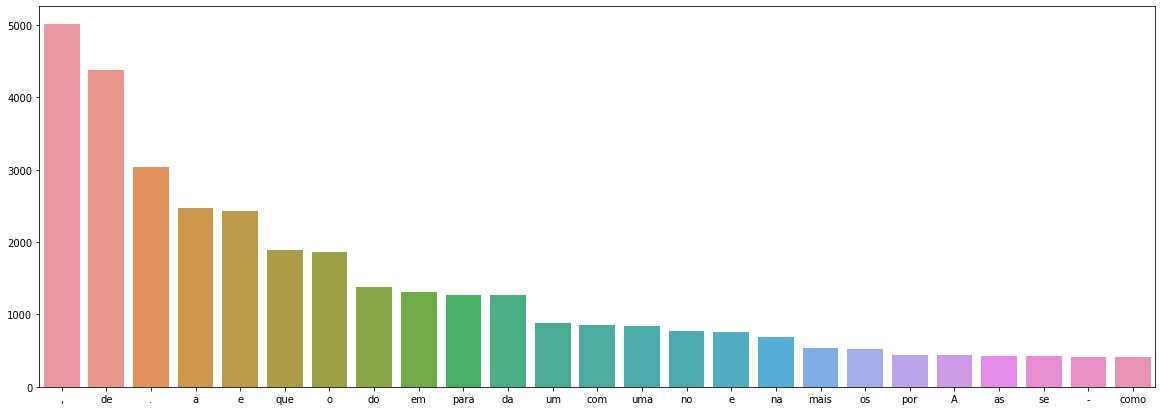

In [16]:
text_variable = 'TEXT_VARIABLE'
raw_text_column = df_data[text_variable]
generate_wordcloud(raw_text_column)
print(generate_freq_dist_plot(raw_text_column))

### Symbols and stopwords

As we can see, we have a lot of tokens from text variable being symbols or words that don't have by themselves much meaning. Let's fix that.
We can also strip trailing spaces and remove multiple spaces.

In [26]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese'))).union(set(['anos', 'ano', 'dia', 'dias']))
space_pattern = r'\s\s+'
print("This is the stopword list: ", sorted(list(stopwords_set)))
print("This is the space pattern:", space_pattern)
''' Symbols and punctuation can be extracted after lemmatization '''

This is the stopword list:  ['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'ano', 'anos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'dias', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dã

' Symbols and punctuation can be extracted after lemmatization '

### Lemmatizing and stemming


['tagger', 'sentencizer', 'parser', 'ner']



Documents without lemmatization
pessoas      240
mundo        208
Brasil       181
mulheres     168
vida         147
projeto      137
crianças     133
país         129
história     100
animais       88
trabalho      86
cidade        84
ajudar        82
Rio           80
água          74
Paulo         74
lixo          73
texto         71
pra           68
completo      67
ideia         65
alimentos     64
hoje          63
melhor        63
escola        62
dtype: int64


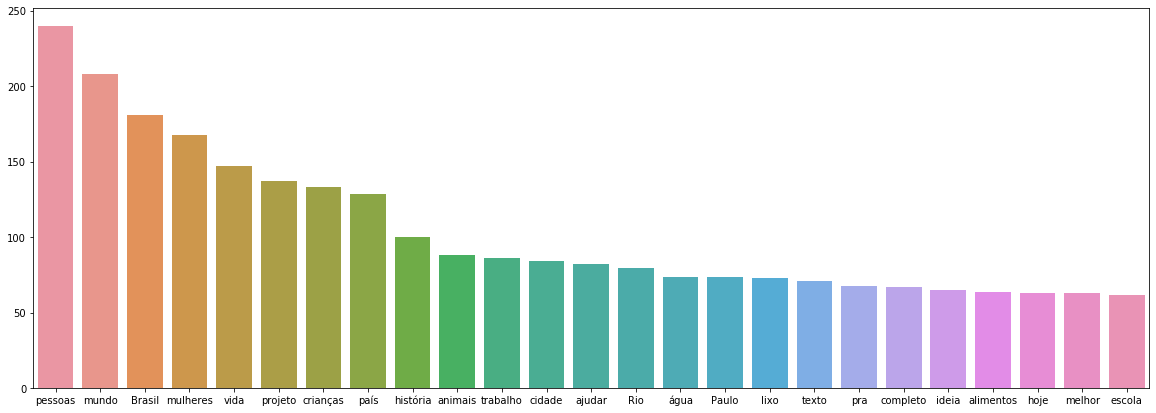

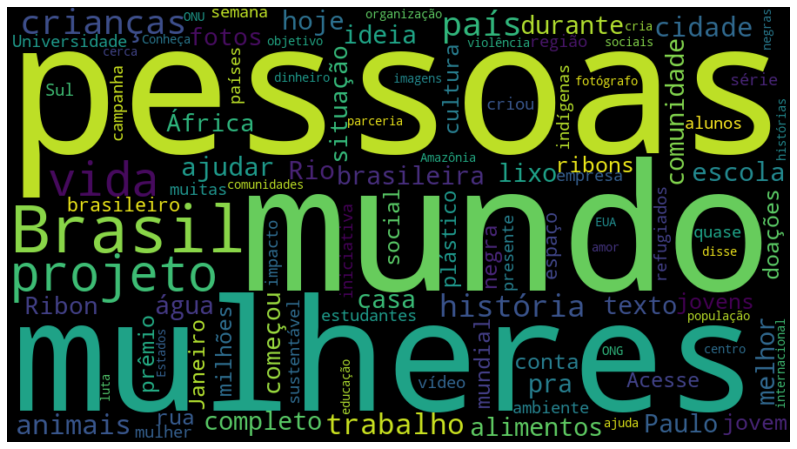

Documents with minor lemmatization
pessoas       246
mundo         224
mulheres      198
brasil        181
projeto       171
vida          152
crianças      137
país          133
história      105
trabalho       92
animais        89
cidade         86
escola         83
rio            83
hoje           82
ajudar         82
lixo           79
durante        78
brasileira     76
água           76
paulo          74
pra            73
texto          71
alimentos      70
melhor         68
dtype: int64


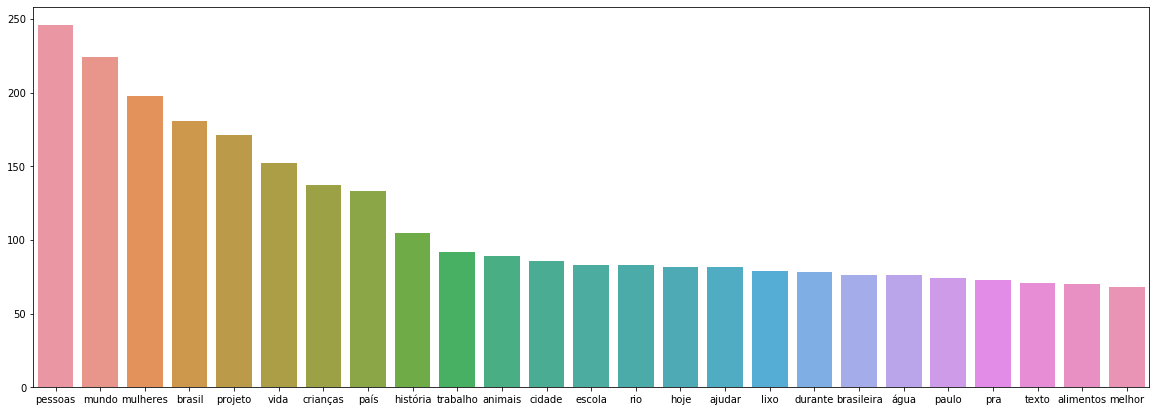

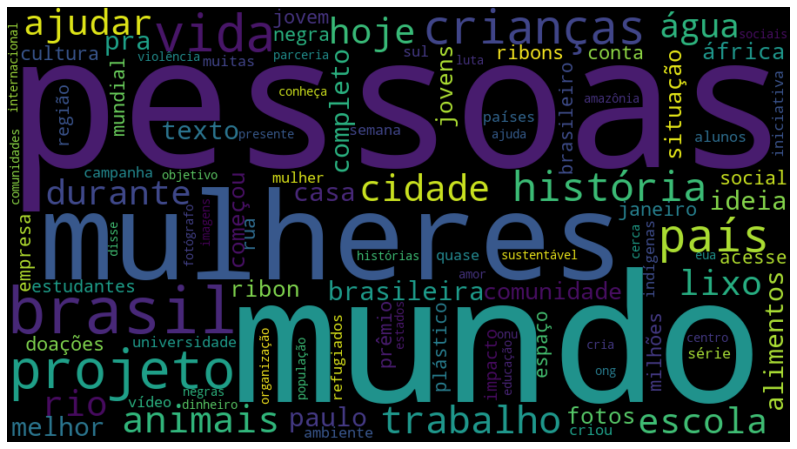

Documents with full lemmatization
pessoa        259
mundo         208
mulher        205
criar         187
Brasil        181
ajudar        170
vidar         169
país          167
trabalhar     153
criança       149
passar        146
brasileiro    139
projeto       137
história      136
negro         111
casar         110
cidade        107
contar        102
comunidade     98
fazer          92
animar         92
jovem          91
viver          91
chegar         88
escola         88
dtype: int64


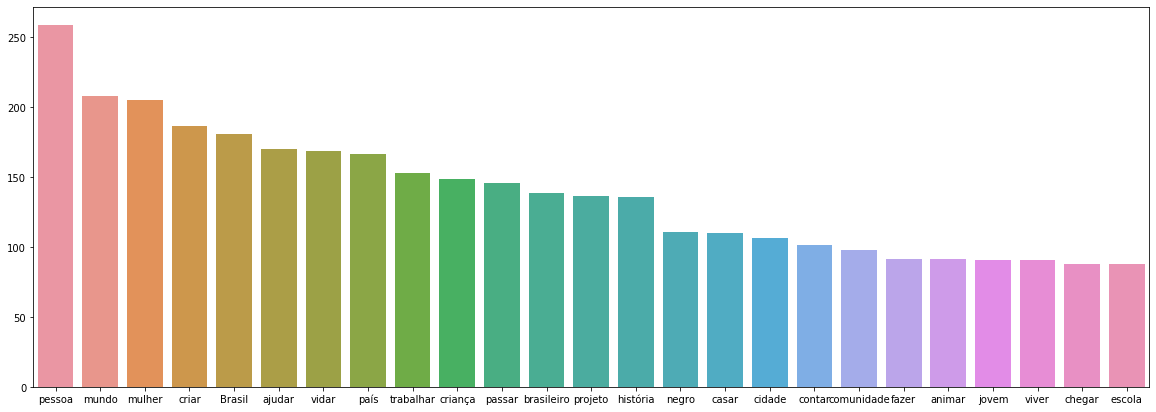

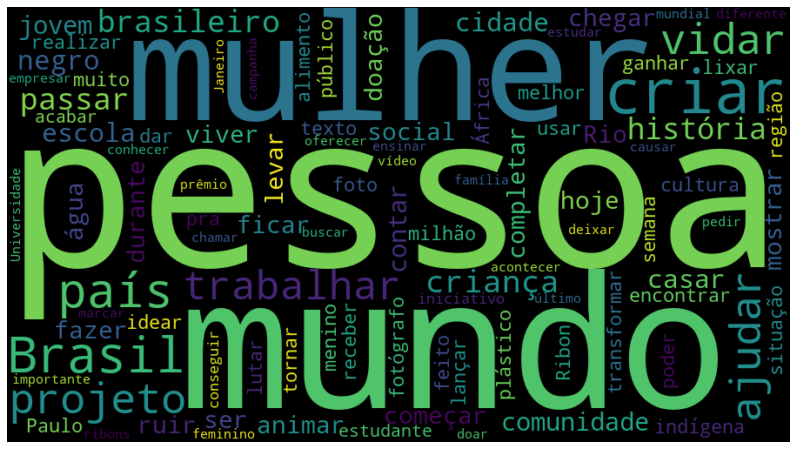

In [18]:
preprocessed_text_data = df_data[text_variable].to_list()
''' Not all variables are being undestood as strings so we have to force it'''

sentencizer = NLP_SPACY.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

tokenized_data = []
semantics_data = []
lemmatized_doc = []
normalized_doc = []
raw_doc = []
for row in tqdm(preprocessed_text_data):
    doc = NLP_SPACY(row)
    preprocessed_doc = [token for token in doc if token.is_alpha and not token.norm_ in stopwords_set]
    tokenized_data.append(preprocessed_doc)
    raw_doc.append(
        " ".join(
            [word.text for word in preprocessed_doc]))
    lemmatized_doc.append(
        " ".join(
            [word.lemma_ for word in preprocessed_doc]))
    normalized_doc.append(
        " ".join(
            [word.norm_ for word in preprocessed_doc]))
    
df_data['RAW_DOC'] = raw_doc
df_data['NORMALIZED_DOC'] = normalized_doc
df_data['LEMMATIZED_DOC'] = lemmatized_doc

print("Documents without lemmatization")
print(generate_freq_dist_plot(df_data['RAW_DOC']))
generate_wordcloud(df_data['RAW_DOC'])
print("Documents with minor lemmatization")
print(generate_freq_dist_plot(df_data['NORMALIZED_DOC']))
generate_wordcloud(df_data['NORMALIZED_DOC'])
print("Documents with full lemmatization")
print(generate_freq_dist_plot(df_data['LEMMATIZED_DOC']))
generate_wordcloud(df_data['LEMMATIZED_DOC'])

### Entity Recognition
Some parts of speech may mislead the model associating classes to certain entities that are not really related to the categories.
The NER model(spacy portuguese) we are using uses the following labels:

| TYPE | DESCRIPTION |
|------|-------------------------------------------------------------------------------------------------------------------------------------------|
| PER | Named person or family. |
| LOC | Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains). |
| ORG | Named corporate, governmental, or other organizational entity. |
| MISC | Miscellaneous entities, e.g. events, nationalities, products or works of art. |

Let's take a look at the named persons or families

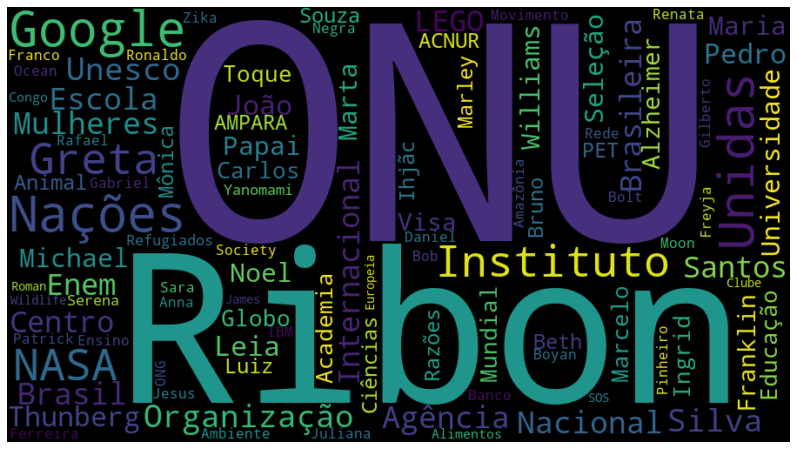

ONU              39
Ribon            20
Nações           19
Google           18
Unidas           18
Greta            14
Instituto        14
Silva            13
Organização      13
Escola           12
Mulheres         12
Agência          12
Brasil           12
Nacional         12
Internacional    11
Santos           11
Brasileira       11
Centro           10
Leia             10
João             10
Pedro            10
Thunberg         10
LEGO              9
Papai             9
Williams          9
dtype: int64


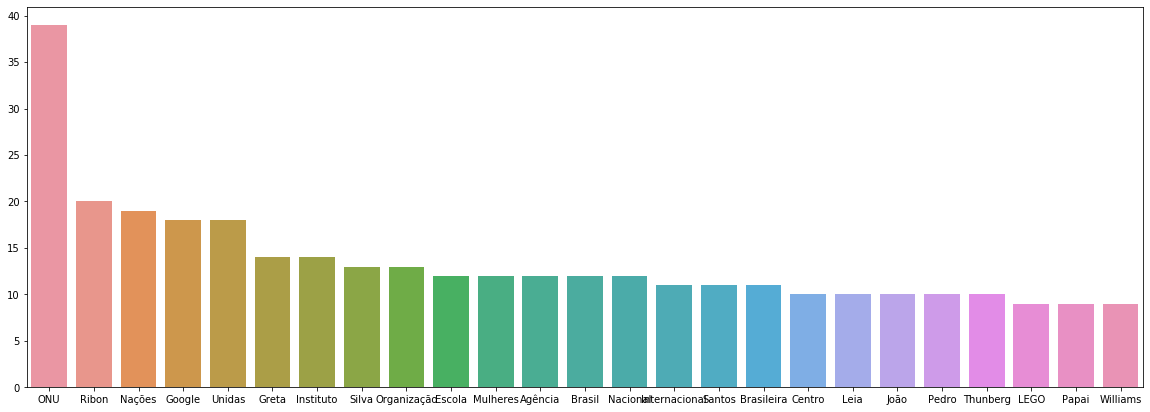

In [125]:
''' First we take a look at the found entities'''
entities_lists = []
entity_unwanted_types = set(['PER', 'ORG'])

for doc in tokenized_data:
    entities_text = ""
    for token in doc:
        if not token.ent_type_:
            continue
        if token.ent_type_ in entity_unwanted_types:
            entities_text += " " + token.text
    entities_text = entities_text.strip()
    entities_lists.append(entities_text)
            
df_data['ENTITIES'] = entities_lists
generate_wordcloud(df_data['ENTITIES'])
print(generate_freq_dist_plot(df_data['ENTITIES']))

### Removing Entities

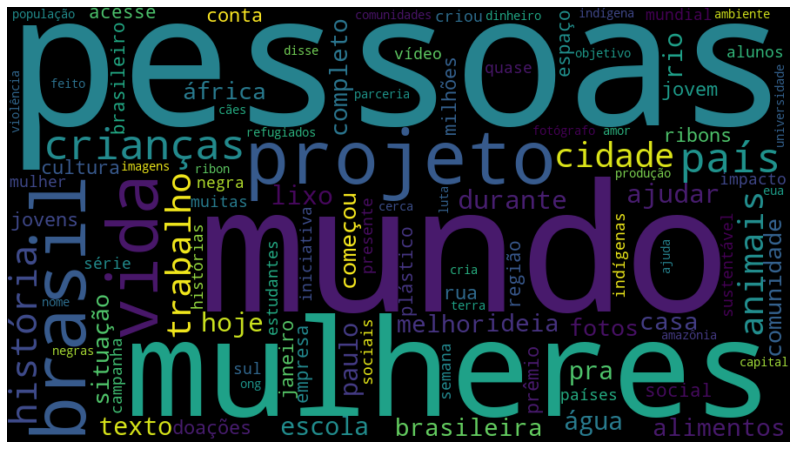

pessoas     246
mundo       222
mulheres    186
projeto     171
brasil      169
vida        151
crianças    137
país        133
história    104
trabalho     90
animais      89
cidade       86
ajudar       82
hoje         82
rio          80
lixo         79
durante      78
água         75
pra          73
texto        71
escola       71
paulo        71
melhor       68
completo     67
casa         65
dtype: int64


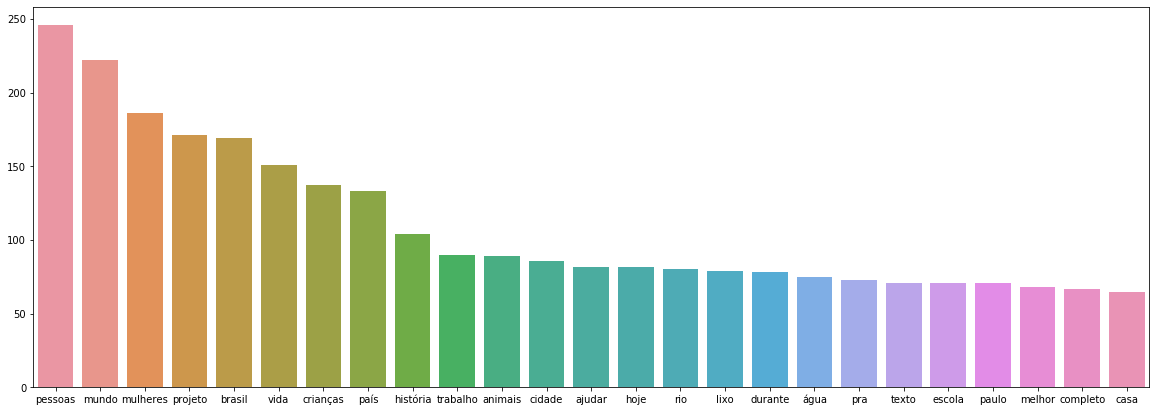

In [126]:
processed_tokenized_data = []
processed_doc_text = []
for doc in tokenized_data:
    entities_text = ""
    processed_doc = []
    for token in doc:
        if not token.ent_type_:
            processed_doc.append(token)
        elif not token.ent_type_ in entity_unwanted_types:
            processed_doc.append(token)
    processed_tokenized_data.append(processed_doc)
    processed_doc_text.append(" ".join([word.norm_ for word in processed_doc ]))

''' Processing text on entity level'''
df_data['PROCESSED_DOC'] = processed_doc_text
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

### POS Analysis
Let's take a look in the parts of speech presents in the dataset

NOUN     16636
VERB      8942
PROPN     5495
ADJ       4685
SYM       1010
ADV        795
AUX        380
DET        229
ADP        194
PRON        63
X           46
NUM         10
SCONJ        7
CCONJ        2
PUNCT        2
dtype: int64


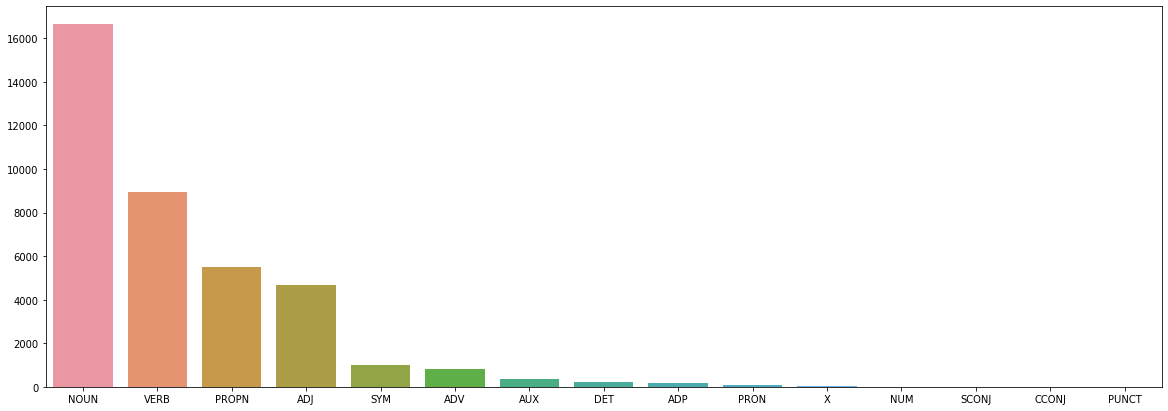

In [127]:
semantics_data = []
for doc in processed_tokenized_data:
    semantics_data.append(" ".join([word.pos_ for word in doc]))

df_data['SEMANTICS'] = semantics_data
print(generate_freq_dist_plot(df_data['SEMANTICS']))

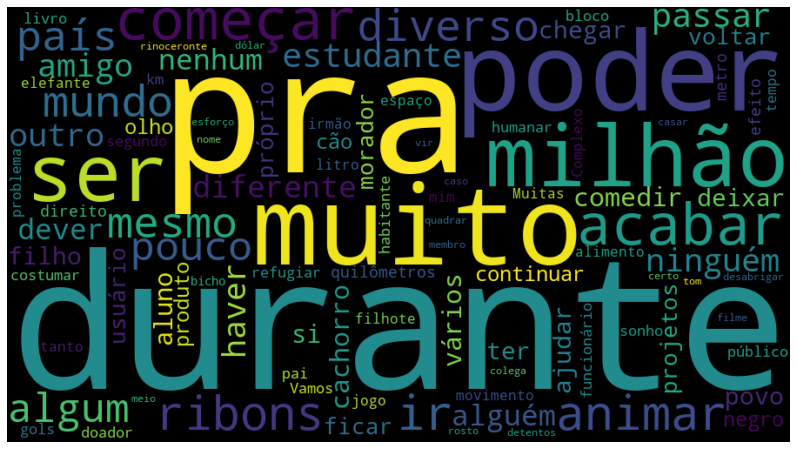

pra          67
poder        64
muito        63
durante      59
milhão       50
ser          44
começar      38
acabar       38
ir           25
animar       25
ribons       24
mundo        22
mesmo        22
diverso      22
país         21
algum        19
estudante    19
pouco        19
Durante      19
passar       19
outro        17
haver        17
amigo        17
diferente    15
ninguém      15
dtype: int64


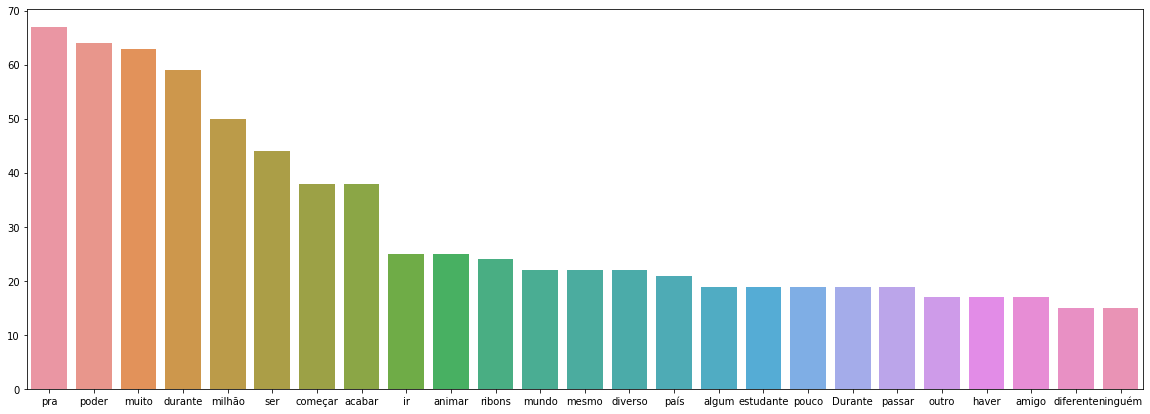

In [128]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

unwanted_pos_text = []
for doc in processed_tokenized_data:
    unwanted_pos_text.append(
        " ".join(
            [word.lemma_ if not str(word.pos_) in ALLOWED_POS else "" for word in doc]))
    
df_data['UNWANTED_POS'] = unwanted_pos_text
generate_wordcloud(df_data['UNWANTED_POS'])
print(generate_freq_dist_plot(df_data['UNWANTED_POS']))

### Removing POS

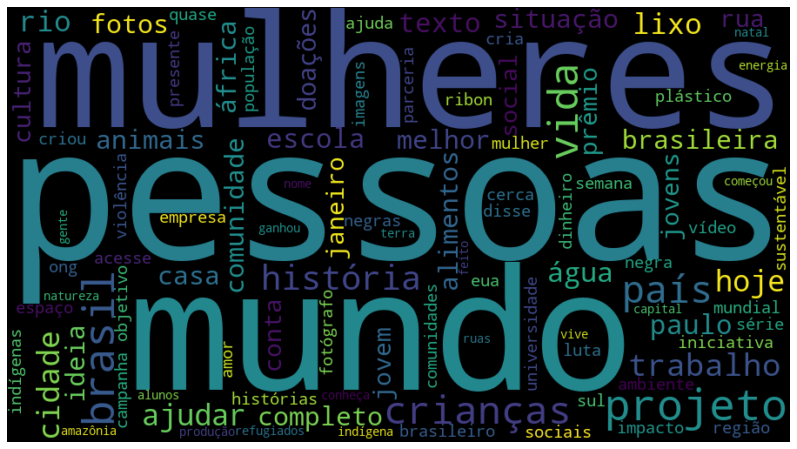

pessoas       246
mundo         200
mulheres      185
projeto       171
brasil        169
vida          151
crianças      137
país          132
história      104
trabalho       90
cidade         86
hoje           82
ajudar         82
lixo           79
rio            79
água           75
paulo          71
texto          71
escola         71
completo       67
melhor         66
casa           65
ideia          65
brasileira     65
animais        64
dtype: int64


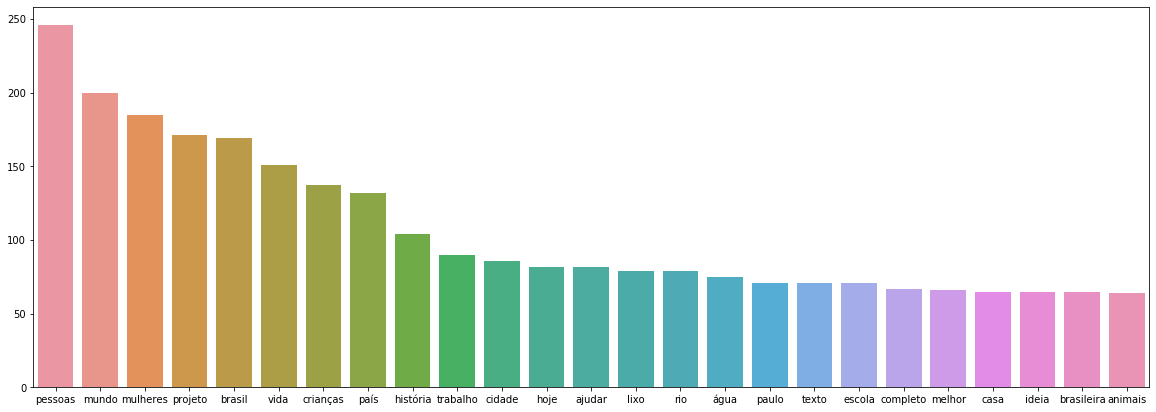

In [129]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

processed_doc = []
processed_doc_tokens = []
for doc in processed_tokenized_data:
    doc_tokens = [word.norm_ if str(word.pos_) in ALLOWED_POS else "" for word in doc]
    processed_doc_tokens.append(doc_tokens)
    processed_doc.append(
        " ".join(doc_tokens))

df_data['PROCESSED_DOC'] = processed_doc
df_data['PROCESSED_DOC_TOKENS'] = processed_doc_tokens
''' Processing text on entity level again '''
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

In [130]:
""" Removing extra spaces originated from processing """
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(space_pattern, " ").str.strip()
df_data['UNWANTED_POS'] = df_data['UNWANTED_POS'].str.replace(space_pattern, " ").str.strip()

### Viewing the most common words for each label

Label:  ANIMAIS
animais        47
cães           26
vida           22
animal         15
elefantes      13
extinção       13
pessoas        13
rua            12
gatos          11
amor           10
abandonados    10
espécie        10
espécies       10
país            9
situação        9
vídeo           9
ong             9
quênia          8
texto           8
ideia           8
mundo           8
cidade          8
cão             8
preservação     7
abrigo          7
dtype: int64


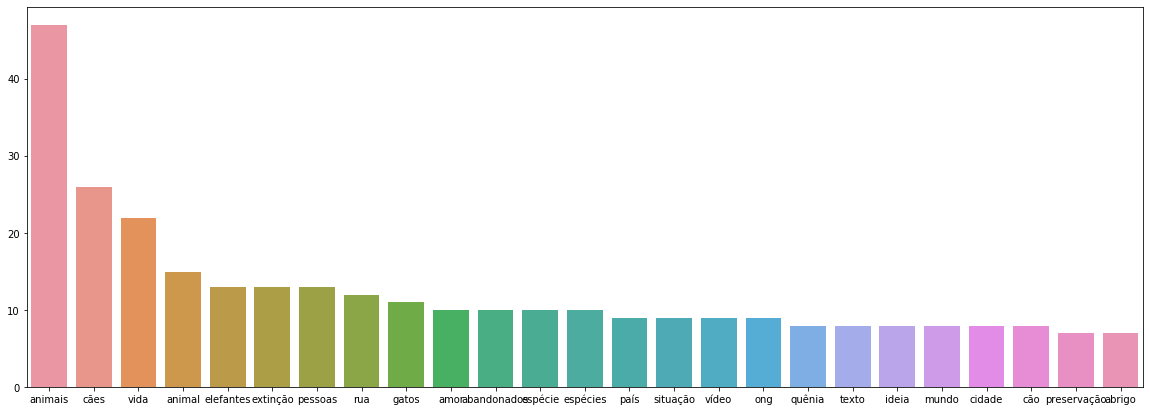

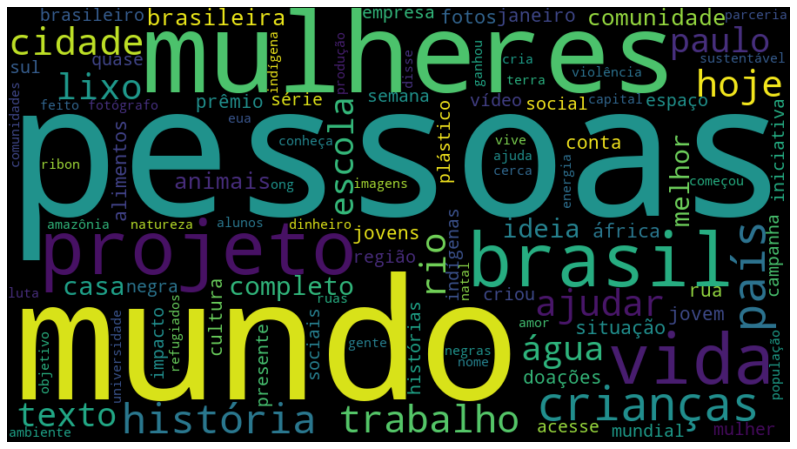

Label:  DIVERSIDADE
mulheres           29
pessoas            27
crianças           17
deficiência        15
mundo              15
braille            14
projeto            13
brasil             13
luta               10
lei                10
nome               10
hoje                9
visuais             9
pele                9
diversidade         9
inclusão            9
gênero              8
social              8
negra               8
empresa             8
sociais             8
desenvolvimento     8
direitos            7
país                7
campanha            7
dtype: int64


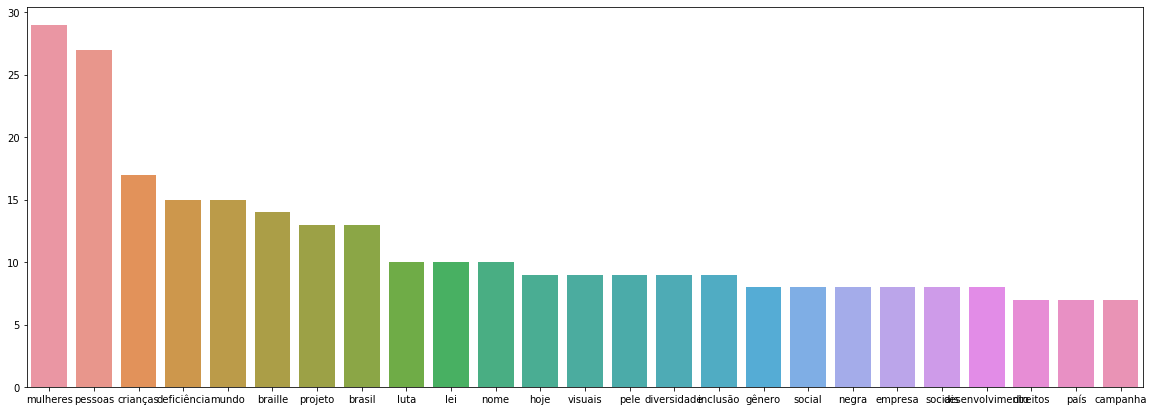

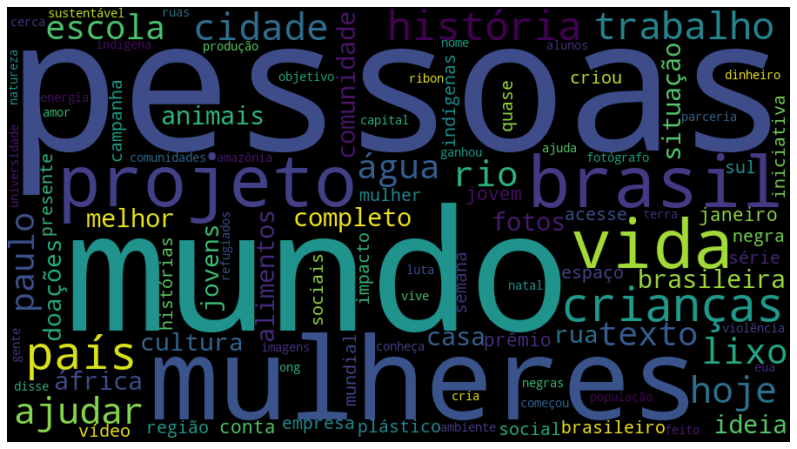

Label:  EDUCACAO
crianças        35
escola          34
projeto         28
alunos          21
educação        17
escolas         17
brasil          16
mundo           15
rio             13
pessoas         12
cidade          11
trabalho        11
universidade    11
música          11
melhor          11
país            11
professor       10
estudantes      10
aulas           10
casa            10
janeiro          9
pública          9
vida             9
livros           9
espaço           8
dtype: int64


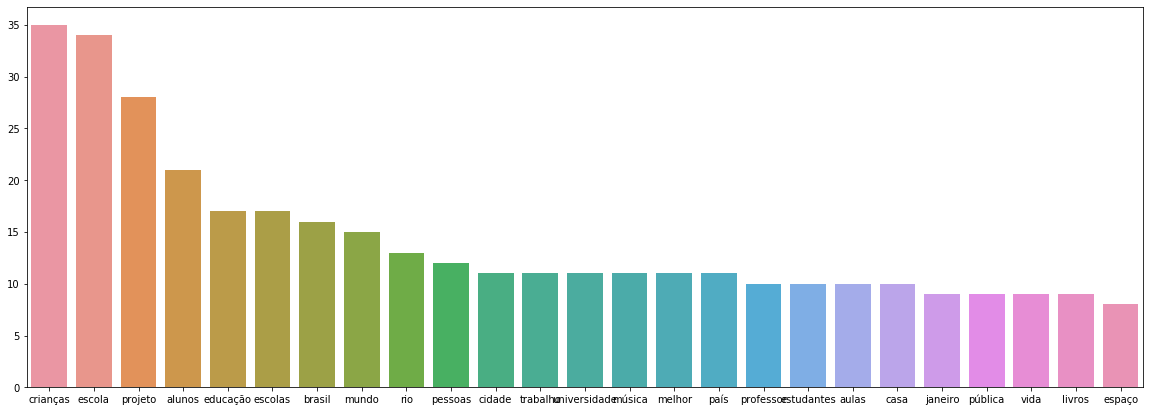

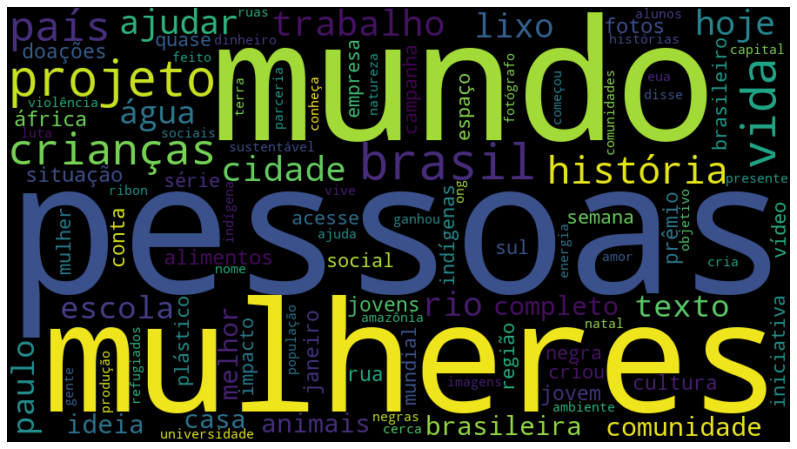

Label:  CIENCIA
água           14
espaço         11
mulheres       11
jovem          10
tecnologia      9
prêmio          9
criou           9
brasileira      8
espacial        8
ciência         7
pessoas         7
sinais          7
cientistas      6
ideia           6
unidos          6
brasileiro      6
estados         6
garrafa         6
lixo            6
transformar     5
plástico        5
missão          5
astronautas     5
imagens         5
consumo         5
dtype: int64


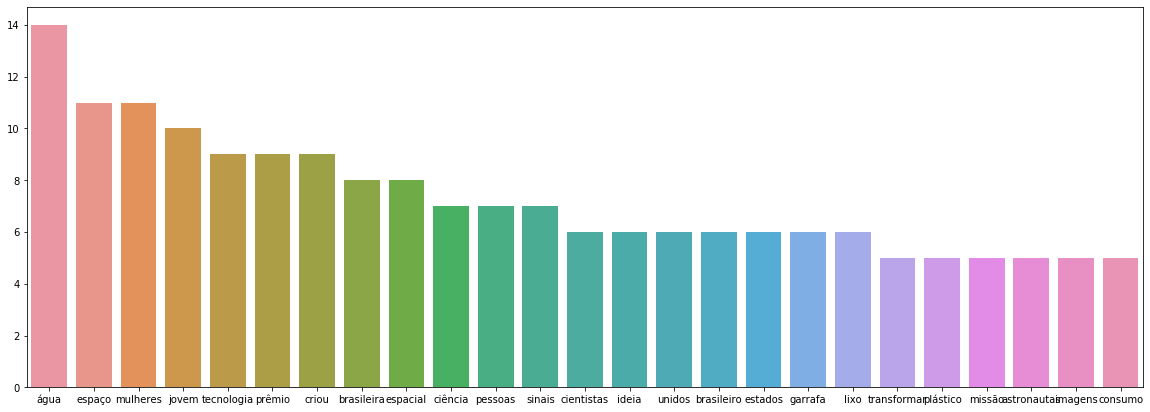

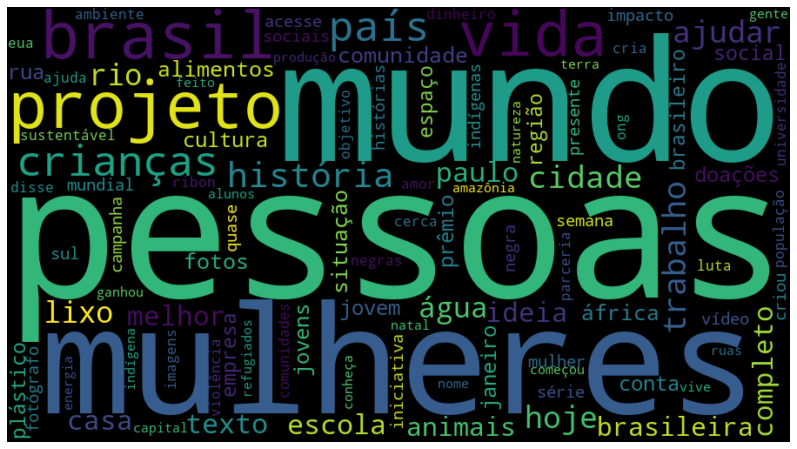

Label:  CULTURA
brasil         41
mulheres       28
rio            25
história       23
mundo          22
cultura        20
janeiro        18
cultural       17
pessoas        17
fotos          15
vida           15
texto          15
completo       14
fotógrafo      13
carnaval       13
escola         12
acesse         12
resistência    12
patrimônio     12
negros         11
hoje           11
paulo          11
brasileira     10
arte           10
terra          10
dtype: int64


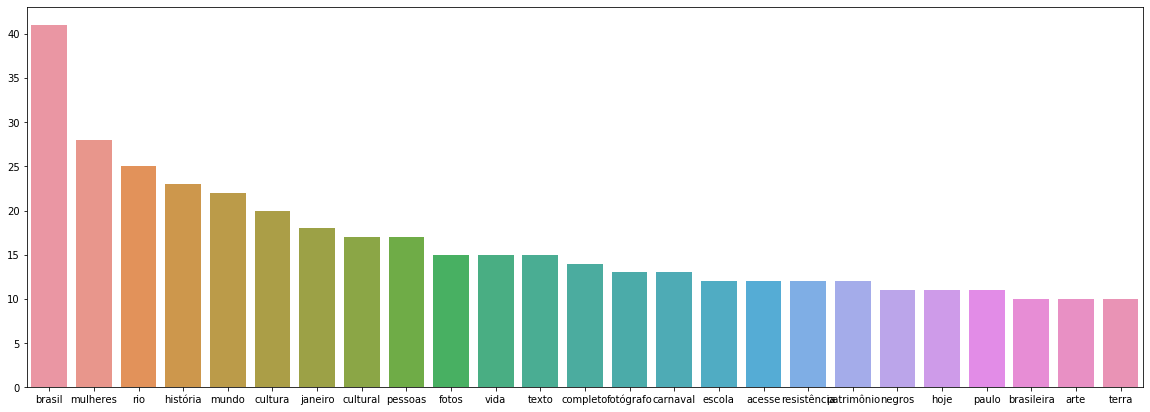

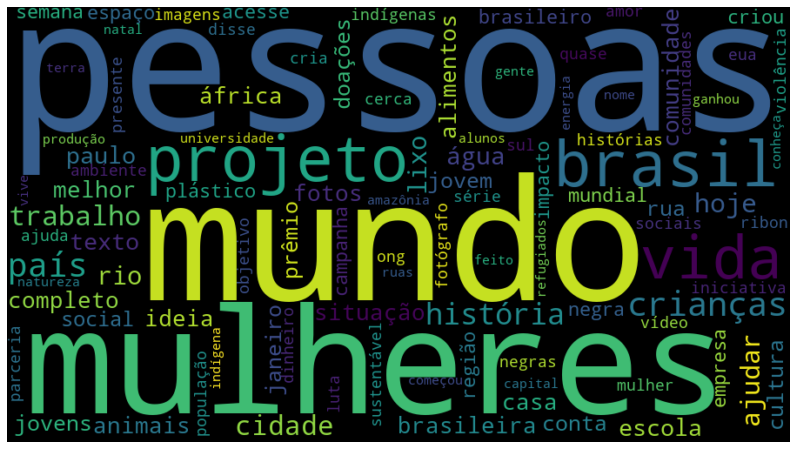

Label:  EMPREENDEDORISMO
mulheres       29
projeto        26
pessoas        18
alimentos      15
violência      13
mundo          12
trabalho       10
brasil         10
situação        9
algodão         9
comunidades     9
produção        8
desperdício     8
iniciativa      8
comunidade      7
país            7
sp              7
vida            7
negras          7
paulo           6
máquina         6
costura         6
cidade          6
carreira        6
social          6
dtype: int64


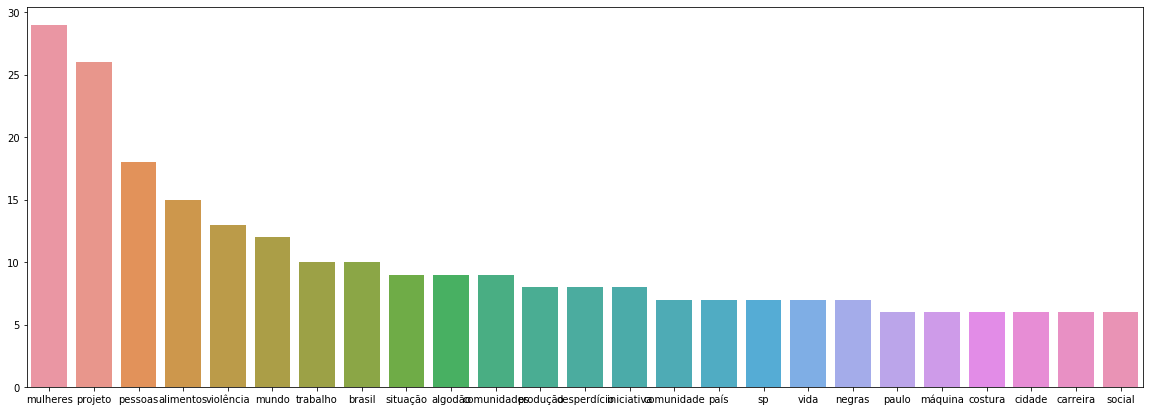

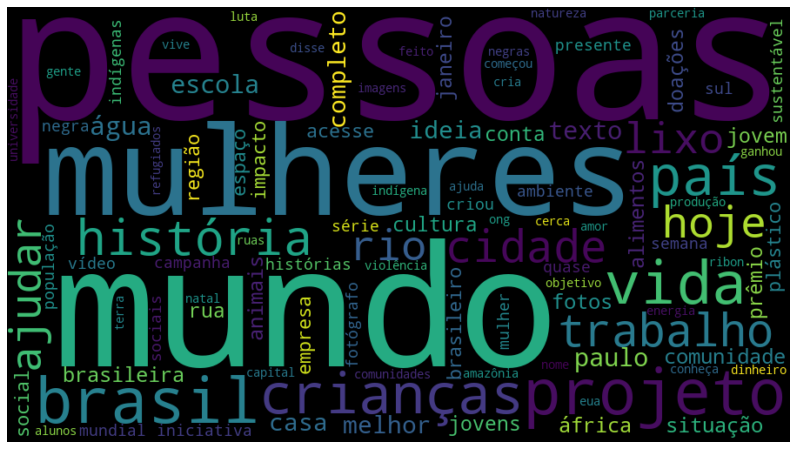

Label:  ESPORTE
futebol         25
mundo           19
copa            18
seleção         14
mundial         14
brasil          11
história        11
histórias       10
projeto         10
feminina        10
feminino         9
pessoas          8
país             8
atleta           7
melhor           7
mulheres         7
esporte          7
campeonato       7
jogos            7
participação     6
camisa           6
conta            6
masculino        6
jogadora         6
atletas          6
dtype: int64


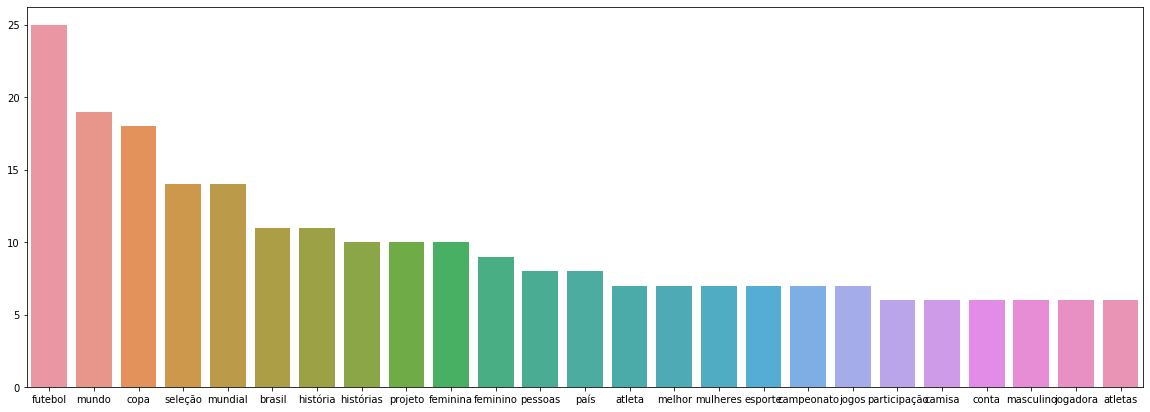

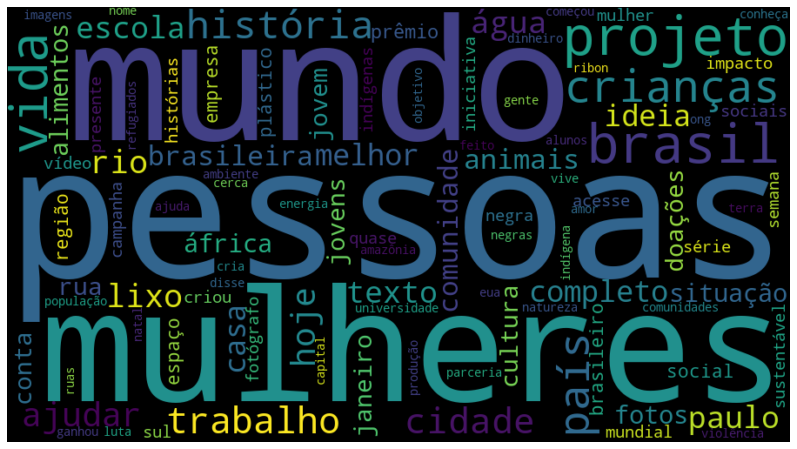

Label:  CELEBRACAO
prêmio           26
brasileira       18
mulheres         17
trabalho         15
brasil           14
mundo            13
jovens           13
ciência          12
nobel            12
país             11
vida             10
pessoas          10
internacional    10
bióloga          10
projeto          10
negra             9
paz               8
estudantes        7
brasileiro        7
história          7
recebe            7
água              6
notícias          6
jovem             6
ficou             6
dtype: int64


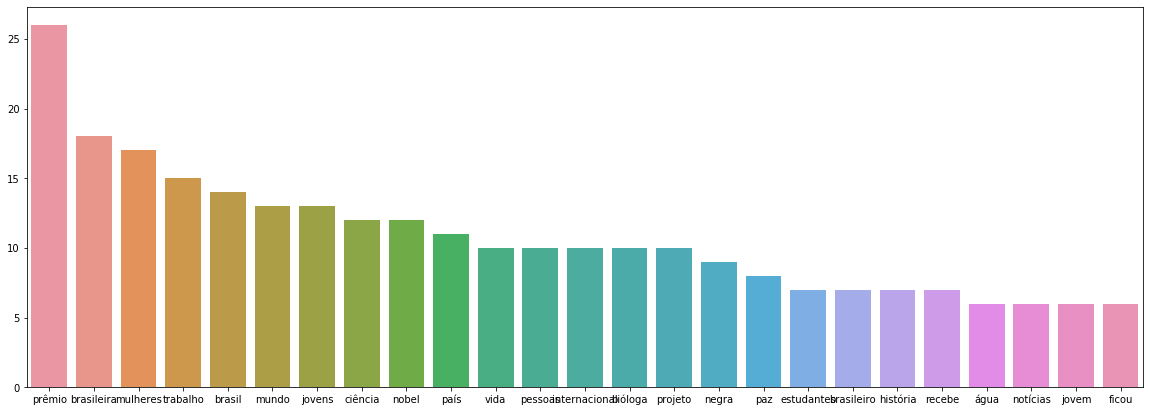

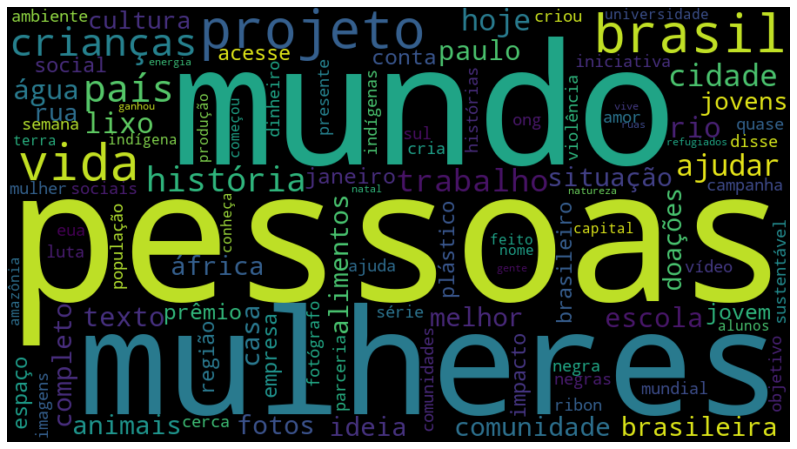

Label:  PROPOSITO
doações       38
ribon         31
ribons        26
pessoas       25
mundo         23
impacto       20
presente      19
completo      16
comunidade    16
ajudar        16
doados        15
texto         15
boas          14
doar          14
app           14
projeto       13
hoje          11
crianças      11
doação        11
abaixo        10
causas        10
visa           9
história       9
juntos         9
botão          9
dtype: int64


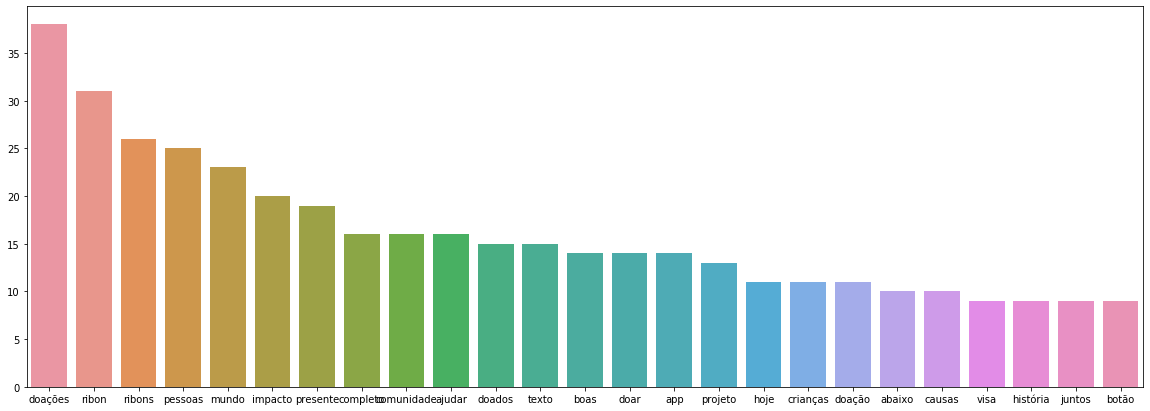

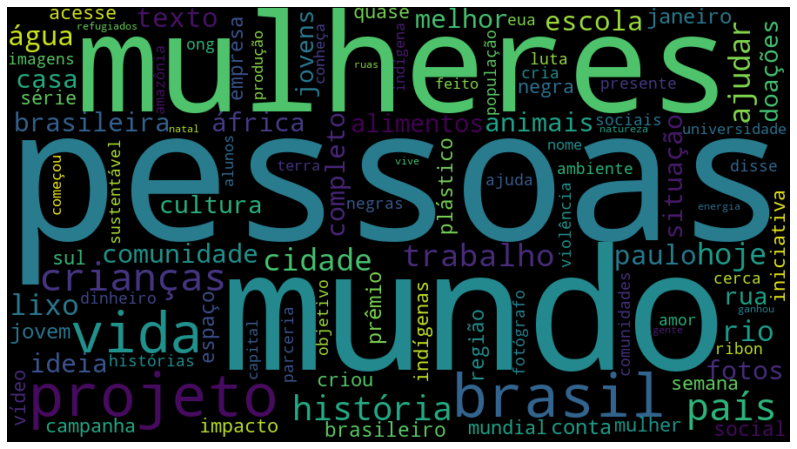

Label:  ETNIAS
mulheres      33
país          29
indígenas     28
áfrica        23
fotos         22
brasil        19
mundo         18
história      16
indígena      16
cultura       16
pessoas       15
fotógrafo     15
série         15
vida          14
hoje          14
continente    14
imagens       13
texto         12
completo      11
região        11
acesse        10
guerra        10
projeto        9
jeito          9
povos          8
dtype: int64


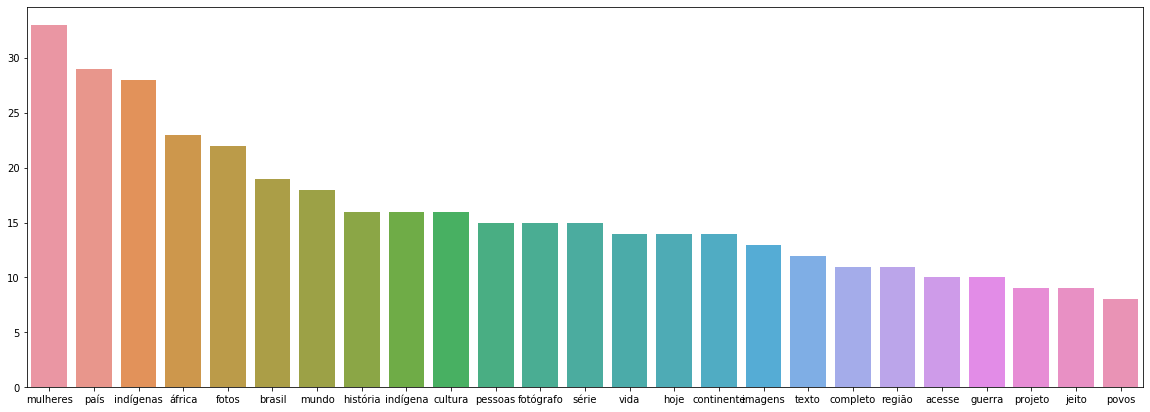

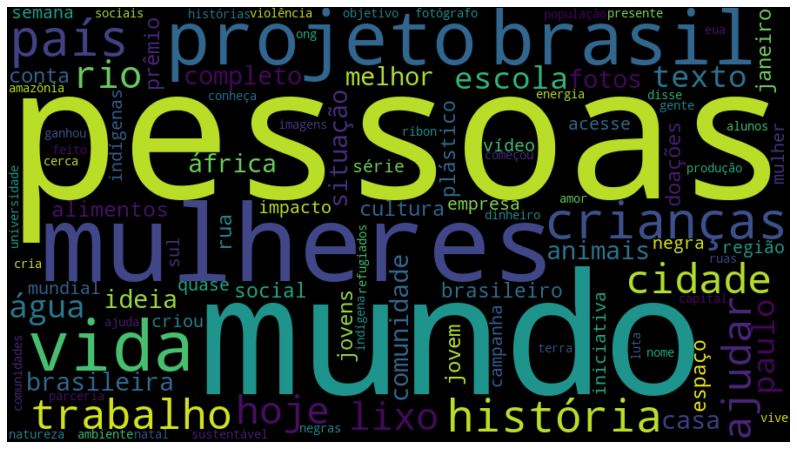

Label:  SAUDE
pessoas      15
morte         8
doença        7
vida          7
escrever      6
natureza      6
saúde         6
pacientes     6
crianças      5
melhor        5
projeto       5
brasil        5
ajudar        5
médico        4
cirurgia      4
ouvido        4
criou         4
the           4
contato       4
ajuda         4
diversão      4
mundo         4
acesso        4
doenças       4
corpo         4
dtype: int64


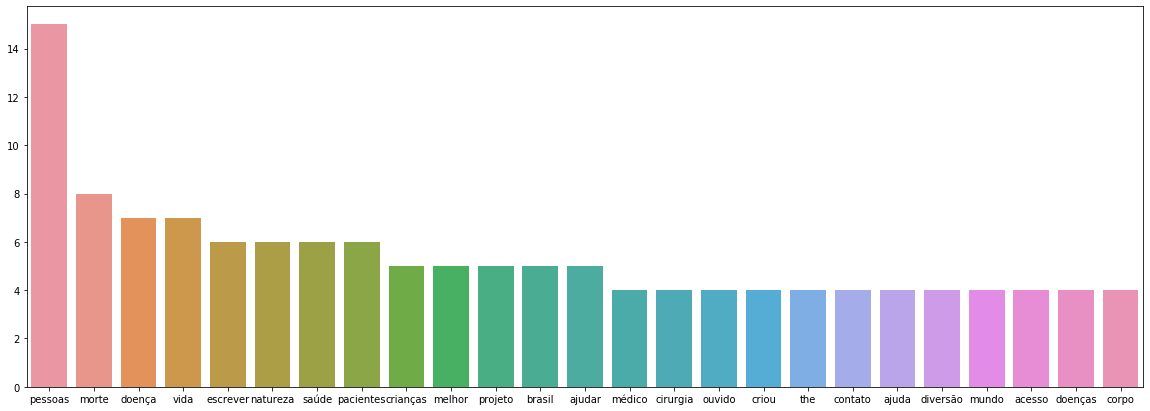

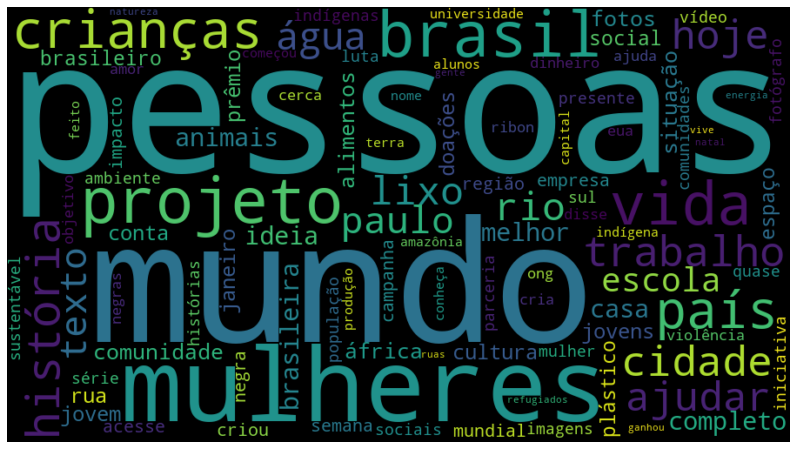

Label:  SCARCE_GROUP
crianças    22
mãe         16
vida        13
amor        12
história    11
mundo       10
pessoas     10
filha       10
idosos       9
pai          8
mães         8
cidade       8
natal        8
filho        8
fotos        6
hoje         6
escola       6
casa         6
paulo        6
câncer       6
vídeo        5
momentos     5
pais         5
cabelo       5
bebês        5
dtype: int64


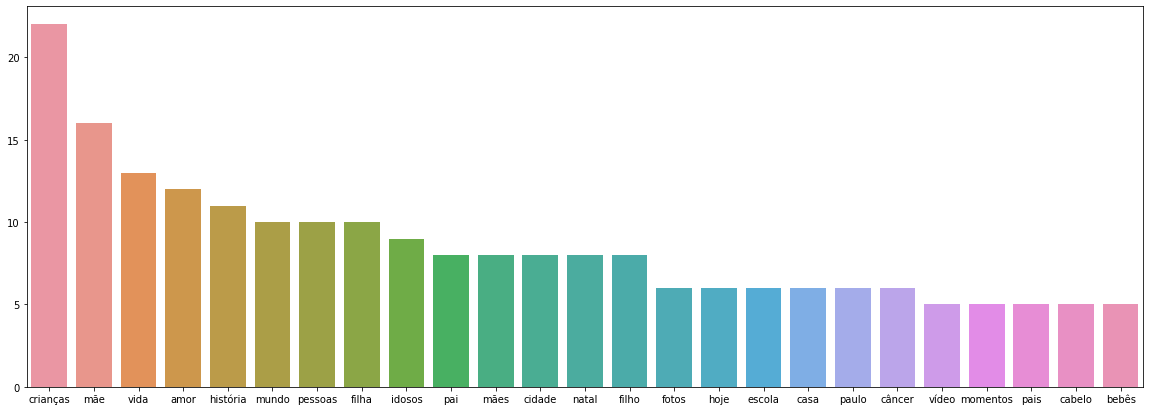

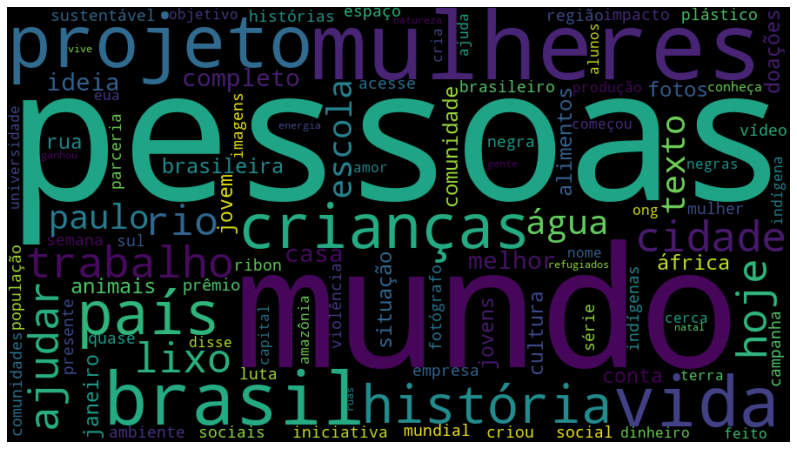

Label:  ECOLOGIA
lixo           54
plástico       36
água           33
mundo          24
energia        19
sustentável    19
pessoas        18
empresa        17
garrafas       16
vida           16
brasil         16
amazônia       16
árvores        14
embalagens     14
ideia          14
ambiente       14
casa           13
país           12
projeto        12
feita          12
cidade         11
plásticas      11
material       11
quase          10
uso            10
dtype: int64


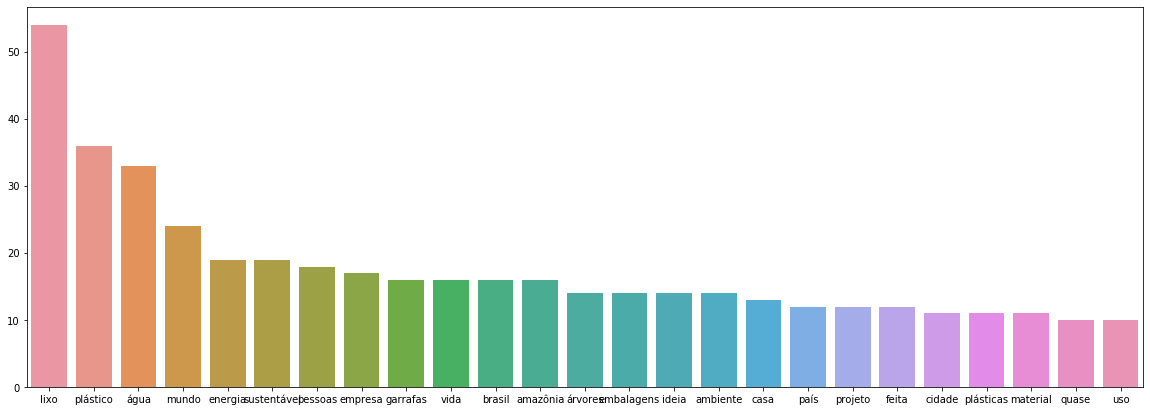

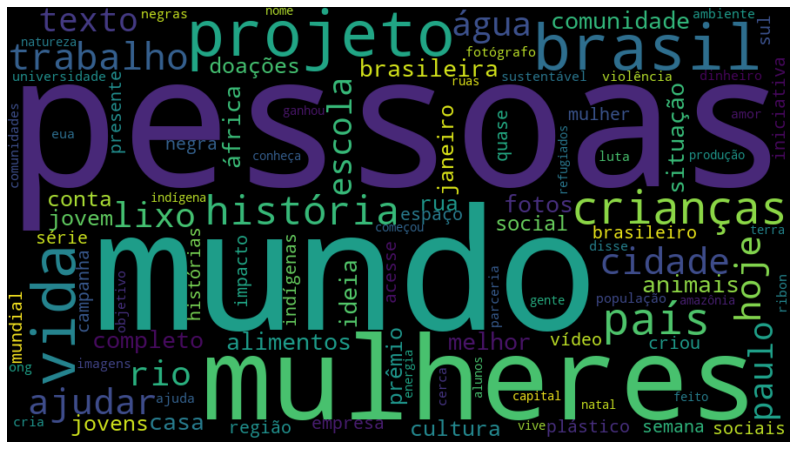

Label:  SOLIDARIEDADE
pessoas       51
ajudar        25
projeto       22
alimentos     21
crianças      20
vida          19
situação      18
rua           17
refugiados    14
mulheres      13
brumadinho    13
rio           13
país          13
brasil        12
mundo         12
comprar       11
ajuda         11
comida        10
cidade        10
homem         10
campanha       9
ruas           8
eua            8
vítimas        8
lixo           8
dtype: int64


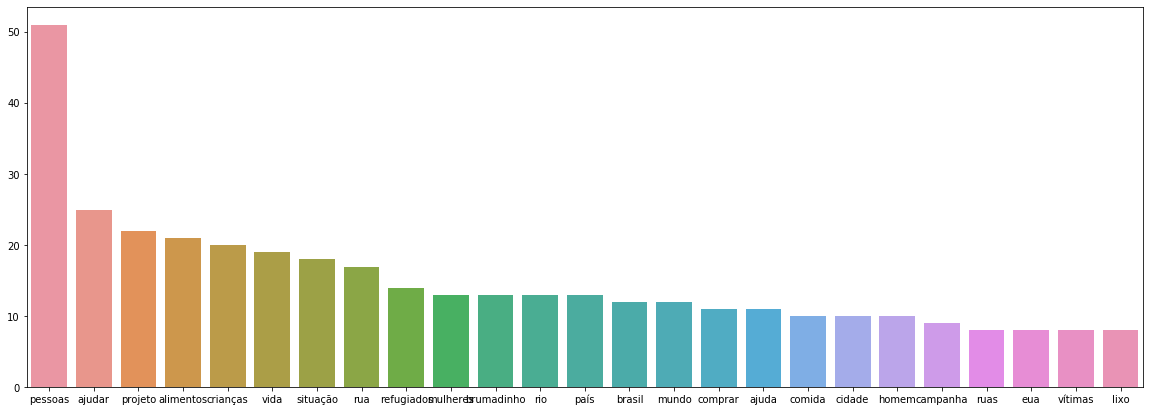

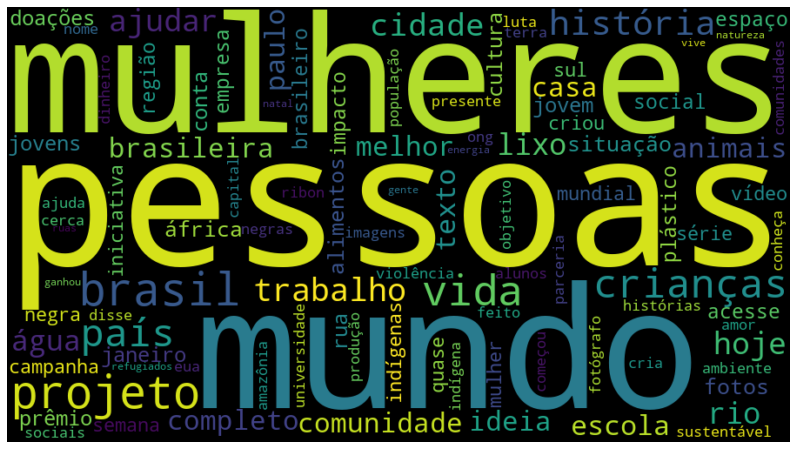

In [131]:
target_labels = df_data[TARGET_VARIABLE].unique()

for label in target_labels:
    words_for_label = df_data[df_data[TARGET_VARIABLE] == label]
    print("Label: ", label)
    print(generate_freq_dist_plot(words_for_label['PROCESSED_DOC']))
    generate_wordcloud(df_data['PROCESSED_DOC'])

### Storing partial progress

In [132]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_processed_data.xlsx"

In [133]:
df_data.to_excel(excel_filename)

 ## Text Parser(Counting and vectorizing)
 Now we have clear tokens we can measure how much they affect the outcome prediction and how many of them exist in each sample.

In [134]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 1774
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LABEL_TRAIN           1679 non-null   object 
 1   TEXT_VARIABLE         1679 non-null   object 
 2   RAW_DOC               1679 non-null   object 
 3   NORMALIZED_DOC        1679 non-null   object 
 4   LEMMATIZED_DOC        1679 non-null   object 
 5   ENTITIES              816 non-null    object 
 6   PROCESSED_DOC         1677 non-null   object 
 7   SEMANTICS             1677 non-null   object 
 8   UNWANTED_POS          811 non-null    object 
 9   PROCESSED_DOC_TOKENS  1679 non-null   object 
 10  TOPIC_0               1679 non-null   float64
 11  TOPIC_1               1679 non-null   float64
 12  TOPIC_2               1679 non-null   float64
 13  TOPIC_3               1679 non-null   float64
 14  TOPIC_4               1679 non-null   float64
 15  TOPIC_5              

### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [135]:
missing_variables = ['ENTITIES', 'UNWANTED_POS']
df_processed_data = df_processed_data.drop(columns=missing_variables).dropna()
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 0 to 1774
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LABEL_TRAIN           1677 non-null   object 
 1   TEXT_VARIABLE         1677 non-null   object 
 2   RAW_DOC               1677 non-null   object 
 3   NORMALIZED_DOC        1677 non-null   object 
 4   LEMMATIZED_DOC        1677 non-null   object 
 5   PROCESSED_DOC         1677 non-null   object 
 6   SEMANTICS             1677 non-null   object 
 7   PROCESSED_DOC_TOKENS  1677 non-null   object 
 8   TOPIC_0               1677 non-null   float64
 9   TOPIC_1               1677 non-null   float64
 10  TOPIC_2               1677 non-null   float64
 11  TOPIC_3               1677 non-null   float64
 12  TOPIC_4               1677 non-null   float64
 13  TOPIC_5               1677 non-null   float64
 14  TOPIC_6               1677 non-null   float64
 15  TOPIC_7              

### Choosing best parameters for Counting and Vectorizing

In [136]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0003),
        'vect__max_df': np.arange(0.2, 0.9, 0.3),
        'vect__max_features': [None],
        'vect__ngram_range': [(1, 2), (1, 3), (2, 3)],
        'tfidf__norm': ['l2'],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False],
        'tfidf__sublinear_tf' : [False, True]}

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(df_data['PROCESSED_DOC'].values, df_data[TARGET_VARIABLE])
    results = gs.cv_results_
    print(gs.best_params_)

In [137]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True,
'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007,
'vect__ngram_range': (1, 2)}
'''
''' Text Parser
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

print(count_vectors[0])
print(frequency_vectors[0])

  (0, 1682)	1
  (0, 1703)	1
  (0, 2796)	1
  (0, 3693)	1
  (0, 3693)	0.2855185709414515
  (0, 2796)	0.22682862749151067
  (0, 1703)	0.21118538176970422
  (0, 1682)	0.27646741979733364


In [138]:
''' Let's transform the lemmatized documents into count vectors '''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

mutual_info_vector = mutual_info_classif(count_vectors, df_processed_data[TARGET_VARIABLE]) 
print(mutual_info_vector)

[0.01159371 0.00295302 0.00277418 ... 0.0039515  0.0039515  0.00249319]


In [139]:
print(count_vectorizer.get_feature_names())

['abaixo', 'abaixo ler', 'abaixo média', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abastecer', 'aberta', 'aberto', 'abertura', 'abolir', 'abolir rituais', 'abolição', 'abraçou', 'abre', 'abrem', 'abria', 'abriga', 'abrigar', 'abrigo', 'abrigos', 'abril', 'abril maio', 'abrindo', 'abrindo debate', 'abrir', 'abrir portas', 'abriram', 'abriria', 'abriu', 'absoluta', 'absolutamente', 'absoluto', 'absorvente', 'absorvente sustentável', 'absorventes', 'abstratas', 'abundante', 'abundância', 'acaba', 'acabado', 'acabar', 'acabar fome', 'acabou', 'academia', 'acadêmicos', 'acalmar', 'acarajé', 'acaso', 'aceleradora', 'acelerar', 'acervo', 'acessar', 'acessar tela', 'acesse', 'acesse texto', 'acessibilidade', 'acesso', 'acesso literatura', 'acesso projetos', 'acesso água', 'acessíveis', 'acessíveis pessoas', 'acessível', 'acha', 'achamos', 'achar', 'achava', 'achem', 'acho', 'achou', 'acidentalmente', 'acidente', 'acidente carro', 'acolhe', 'acolher', 'acolhimento', 'acomodar',

## Topic Modelling
One way to approach this problem is to search for unsupervisionised patterns inside data to form topics and then use those topics to classify.

### Trying LDA model

In [184]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

NUM_TOPICS = 30
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=NUM_TOPICS, max_iter = 20, n_jobs=-1)
topics_vectors = lda.fit_transform(count_vectors)
# Print the topics found by the LDA model
print("Topics found via LDA:")

words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join([words[i]
                    for i in topic.argsort()[:-number_words - 1:-1]]))

Topics found via LDA:

Topic #0:
pessoas vida país indígenas lixo terra áfrica trabalho depressão projeto

Topic #1:
mulheres projeto vida cidade áfrica mundo indígena país produções indígenas

Topic #2:
pessoas mundo brasil rua história espaço situação rua crianças rio situação

Topic #3:
pessoas app série fotos história social mundo conta televisão brasil

Topic #4:
pessoas patrimônio brasil mundial história mulheres natal histórias patrimônio cultural lixo

Topic #5:
mundo áfrica mulheres refugiados tóquio países vida água feita lixo

Topic #6:
mulheres projeto fotos brasil pessoas texto mundo crianças incríveis texto completo

Topic #7:
pessoas mundo mulheres casas projeto feminina carnaval futebol leite situação

Topic #8:
crianças mundo notícias visa pessoas violência melhor dinheiro boas casa

Topic #9:
mulheres pessoas negras país rio presente mundo encontrou crianças mulheres negras

Topic #10:
mundo brasil paulo música copa fotos parque humanos impacto samba

Topic #11:
mundo

### Visualizing topics distribution

In [185]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_vectors, count_vectorizer)


pyLDAvis.display(LDAvis_prepared)

### GridSearching best params

In [141]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer(
        max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
    search_tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
    lda = LDA(n_jobs=-1)
    gnb = GaussianNB()

    search_params = {
        'lda__max_iter': [20],
        'lda__n_components': [60]
    } 

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('lda', lda),
        ('gnb', gnb)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(df_data['PROCESSED_DOC'].values, df_data[TARGET_VARIABLE])
    print(gs.best_params_)

### Storing topics scores as variables

In [191]:
''' We'll need the same number of lists as the number of topics  '''
topics_scores = [[] for i in range(NUM_TOPICS)]

''' We then extract each row score to different columns '''
for doc_topics in topics_vectors:
    for i in range(0, NUM_TOPICS):
        if doc_topics[i]:
            topics_scores[i].append(doc_topics[i])
        else: 
            topics_scores[i].append(0)


''' And store then in the data as variables for their respectives rows'''
topics_skl_columns = []
for i in range(0, NUM_TOPICS):
    column_name = 'TOPIC_SKL_' + str(i)
    topics_skl_columns.append(column_name)
    df_processed_data[column_name] = topics_scores[i]

print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 0 to 1774
Data columns (total 68 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LABEL_TRAIN           1677 non-null   object 
 1   TEXT_VARIABLE         1677 non-null   object 
 2   RAW_DOC               1677 non-null   object 
 3   NORMALIZED_DOC        1677 non-null   object 
 4   LEMMATIZED_DOC        1677 non-null   object 
 5   PROCESSED_DOC         1677 non-null   object 
 6   SEMANTICS             1677 non-null   object 
 7   PROCESSED_DOC_TOKENS  1677 non-null   object 
 8   TOPIC_0               1677 non-null   float64
 9   TOPIC_1               1677 non-null   float64
 10  TOPIC_2               1677 non-null   float64
 11  TOPIC_3               1677 non-null   float64
 12  TOPIC_4               1677 non-null   float64
 13  TOPIC_5               1677 non-null   float64
 14  TOPIC_6               1677 non-null   float64
 15  TOPIC_7              

## Trying gensim lda model

In [143]:
''' First let's create a dicitionary for the topics '''
dictionary = gensim.corpora.Dictionary(processed_doc_tokens)

''' Then let's remove some extreme examples '''
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

''' Then create a bow corpus using those tokens '''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_doc_tokens]

''' Then we can use this bow corpus to generate a frenquecy corpus '''
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

''' We can use those frequencies to generate topics '''
NUM_TOPICS = 30
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=4)
corpus_topics = lda_model_tfidf[corpus_tfidf]

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.033*"menino" + 0.029*"brasileiros" + 0.024*"refugiados" + 0.024*"áfrica" + 0.023*"conheça" + 0.021*"outubro" + 0.020*"" + 0.020*"jovens" + 0.019*"ong" + 0.018*"mudar"
Topic: 1 Word: 0.047*"" + 0.021*"sociais" + 0.021*"cultural" + 0.018*"brasil" + 0.016*"gente" + 0.015*"transformar" + 0.014*"país" + 0.014*"extinção" + 0.014*"redes" + 0.013*"água"
Topic: 2 Word: 0.033*"pessoas" + 0.032*"" + 0.029*"câncer" + 0.024*"quase" + 0.022*"deficiência" + 0.021*"forte" + 0.018*"coisas" + 0.016*"social" + 0.014*"indígena" + 0.014*"crianças"
Topic: 3 Word: 0.029*"amor" + 0.028*"" + 0.020*"pessoas" + 0.019*"sucesso" + 0.018*"vida" + 0.018*"mulheres" + 0.017*"vidas" + 0.016*"fazendo" + 0.016*"ajudando" + 0.015*"juntos"
Topic: 4 Word: 0.029*"ajudar" + 0.023*"parceria" + 0.022*"cria" + 0.019*"ler" + 0.019*"" + 0.018*"janeiro" + 0.018*"pessoas" + 0.016*"meninas" + 0.015*"água" + 0.014*"casas"
Topic: 5 Word: 0.039*"pessoas" + 0.038*"recorde" + 0.036*"vídeo" + 0.026*"pessoa" + 0.025*"bairro

### Storing topics scores as variables

In [144]:
''' We'll need the same number of lists as the number of topics  '''
topics_scores = [[] for i in range(NUM_TOPICS)]

''' We then extract each row score to different columns '''
for doc_topics in corpus_topics:
    dict_topics = dict(doc_topics)
    for i in range(0, NUM_TOPICS):
        if i in dict_topics:
            topics_scores[i].append(dict_topics[i])
        else:
            topics_scores[i].append(0)

''' And store then in the data as variables for their respectives rows'''
topics_columns = []
for i in range(0, NUM_TOPICS):
    column_name = 'TOPIC_' + str(i)
    topics_columns.append(column_name)
    df_data[column_name] = topics_scores[i]

print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 1774
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LABEL_TRAIN           1679 non-null   object 
 1   TEXT_VARIABLE         1679 non-null   object 
 2   RAW_DOC               1679 non-null   object 
 3   NORMALIZED_DOC        1679 non-null   object 
 4   LEMMATIZED_DOC        1679 non-null   object 
 5   ENTITIES              1679 non-null   object 
 6   PROCESSED_DOC         1679 non-null   object 
 7   SEMANTICS             1679 non-null   object 
 8   UNWANTED_POS          1679 non-null   object 
 9   PROCESSED_DOC_TOKENS  1679 non-null   object 
 10  TOPIC_0               1679 non-null   float64
 11  TOPIC_1               1679 non-null   float64
 12  TOPIC_2               1679 non-null   float64
 13  TOPIC_3               1679 non-null   float64
 14  TOPIC_4               1679 non-null   float64
 15  TOPIC_5              

### Model Train and Cross-Validation

In [192]:
classifier = RandomForestClassifier(max_depth=4, random_state=0)

pipeline_simple = Pipeline([
    ('classifier', classifier)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    df_processed_data[topics_skl_columns],
    df_processed_data[TARGET_VARIABLE], cv=5)
print("Mean accuracy for explicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.12402629708599858


In [147]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

''' Explicitly using components '''
pipeline_simple = Pipeline([
    ('clf', clf)
])

count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for explicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.6810557456515541


In [148]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

scores = cross_val_score(
    pipeline,
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for implicit pipeline:  0.6016930424864556


### Evaluating the best model

In [149]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE].to_list(),
    test_size=0.33, random_state=42)

''' First we need to instantiate some components again to avoid overfit'''
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

pipeline_simple = Pipeline([
    ('clf', clf)
])

train1 = X_train
labelsTrain1 = y_train
test1 = X_test
labelsTest1 = y_test
"""  train """
pipeline_simple.fit(train1, labelsTrain1)
"""  test """
preds = pipeline_simple.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))

accuracy: 0.6155234657039711
                  precision    recall  f1-score   support

         ANIMAIS       0.85      0.74      0.79        38
     DIVERSIDADE       0.50      0.38      0.43        32
        EDUCACAO       0.90      0.38      0.53        24
         CIENCIA       0.59      0.59      0.59        63
         CULTURA       0.55      0.63      0.59        49
EMPREENDEDORISMO       0.67      0.72      0.69        61
         ESPORTE       0.57      0.52      0.55        46
      CELEBRACAO       0.41      0.60      0.49        15
       PROPOSITO       0.69      0.65      0.67        17
          ETNIAS       0.52      0.61      0.56        44
           SAUDE       0.78      0.82      0.80        55
    SCARCE_GROUP       0.80      0.44      0.57        18
        ECOLOGIA       0.66      0.54      0.59        35
   SOLIDARIEDADE       0.51      0.65      0.57        57

        accuracy                           0.62       554
       macro avg       0.64      0.59    

### Better visualising model classification

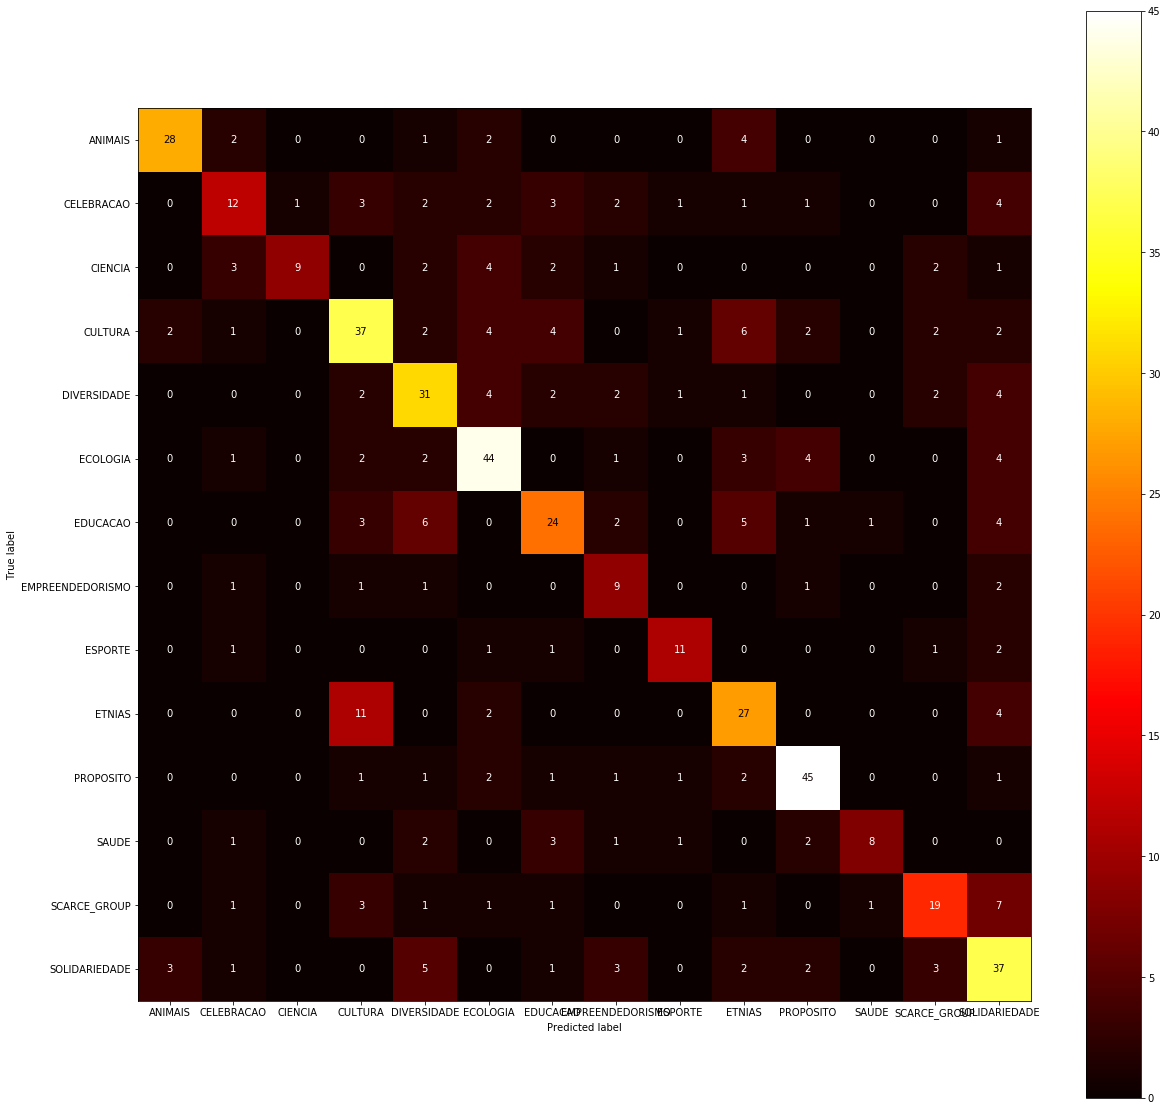

In [150]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

plot_confusion_matrix(pipeline_simple, test1, labelsTest1, cmap='hot', ax=axes)